In [1]:
import os 
os.chdir(r'Q:\sachuriga\Sachuriga_Python/quattrocolo-nwb4fp\src')

from neurochat.nc_data import NData
from neurochat.nc_spike import NSpike
from neurochat.nc_spatial import NSpatial
import neurochat.nc_plot as nc_plot
from neurochat.nc_lfp import NLfp
import matplotlib.pyplot as plt
import numpy as np
from pynwb import NWBHDF5IO
import matplotlib.pyplot as plt
import numpy as np
import math
import pynapple as nap
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

import sys
import nwb4fp.analyses.maps as mapp
from nwb4fp.analyses.examples.tracking_plot import plot_ratemap,plot_path
from nwb4fp.analyses.fields import separate_fields_by_laplace, separate_fields_by_dilation,find_peaks,separate_fields_by_laplace_of_gaussian,calculate_field_centers,distance_to_edge_function, remove_fields_by_area, map_pass_to_unit_circle,which_field,compute_crossings
from elephant.statistics import time_histogram, instantaneous_rate
from nwb4fp.analyses import maps
from nwb4fp.analyses.data import pos2speed,speed_filtered_spikes,load_speed_fromNWB,load_units_fromNWB,get_filed_num,unit_location_ch
from scipy.ndimage import gaussian_filter
import ast
import pandas as pd
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=np.inf)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

fig2 = plt.figure(figsize=(7.2, 12))

Q:\sachuriga\Sachuriga_Python\quattrocolo-nwb4fp\src\nwb4fp\analyses\examples\tracking_plot.py:5: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.measurements import center_of_mass


<Figure size 720x1200 with 0 Axes>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
control_ids = ['65165', '65091', '63383', '66539', '65622']
exp_ids = ['65588', '63385', '66538', '66537', '66922']
all_units_df = pd.read_pickle(r"Q:\sachuriga\CR_CA1_paper\tables/all_units_table_with_waveforms.pkl")
py_pkl = os.path.join(r"Q:\sachuriga\CR_CA1_paper\tables/","functional_properties_with_python_measurements.pkl")
df_good = pd.read_pickle(py_pkl)

df_good['buzaki_py_cell_type']=None
for i in range(len(df_good)):
    if (df_good['peak_to_valley'].iloc[i] <= 0.000425):
        df_good['buzaki_py_cell_type'].iloc[i] = "narrow_spike_interneurons"
    elif (df_good['mean_firing_rate'].iloc[i] >= 10):
        if df_good['peak_to_valley'].iloc[i] <= 0.000425:
            df_good['buzaki_py_cell_type'].iloc[i] = "narrow_spike_interneurons"
        else:
            df_good['buzaki_py_cell_type'].iloc[i] = "wide_spike_interneurons"

    #elif  (df_good['peak_to_valley'].iloc[i] > 0.000425) & (((df_good['tau_rise_python'].iloc[i]) + (df_good['acg_first_positive_x'].iloc[i])) >= 6):
    elif  (df_good['peak_to_valley'].iloc[i] > 0.000425) & ((df_good['tau_rise_python'].iloc[i])  >= 6):
        df_good['buzaki_py_cell_type'].iloc[i] = "wide_spike_interneurons"
    #elif (df_good['peak_to_valley'].iloc[i] > 0.000425) & (df_good['mean_firing_rate'].iloc[i] < 10) & (((df_good['tau_rise_python'].iloc[i]) + (df_good['acg_first_positive_x'].iloc[i])) < 6):
    elif (df_good['peak_to_valley'].iloc[i] > 0.000425) & (df_good['mean_firing_rate'].iloc[i] < 10) & ((df_good['tau_rise_python'].iloc[i])  < 6):
        df_good['buzaki_py_cell_type'].iloc[i] = "pyramidal"

all_units_df.reset_index(drop=True)
# Function to normalize waveforms
def normalize_waveform(wave):
    min_val = np.min(wave)
    return wave / abs(min_val)

# Filter data for control and experimental groups
control_pyramidal = all_units_df[(all_units_df['animal_id'].isin(control_ids)) & (all_units_df['buzaki_py_cell_type'] == 'pyramidal') & (all_units_df['session'] == 'A')]
exp_pyramidal = all_units_df[(all_units_df['animal_id'].isin(exp_ids)) & (all_units_df['buzaki_py_cell_type'] == 'pyramidal')& (all_units_df['session'] == 'A')]
# control_interneuron = all_units_df[(all_units_df['animal_id'].isin(control_ids)) & ((all_units_df['buzaki_py_cell_type'] == "narrow_spike_interneurons")|(all_units_df['buzaki_py_cell_type'] == "wide_spike_interneurons"))& (all_units_df['session'] == 'A')]
# exp_interneuron = all_units_df[(all_units_df['animal_id'].isin(exp_ids)) & ((all_units_df['buzaki_py_cell_type'] == "narrow_spike_interneurons")|(all_units_df['buzaki_py_cell_type'] == "wide_spike_interneurons")) & (all_units_df['session'] == 'A')]


control_interneuron = all_units_df[(all_units_df['animal_id'].isin(control_ids)) & ((all_units_df['buzaki_py_cell_type'] == "narrow_spike_interneurons"))& (all_units_df['session'] == 'A')]
exp_interneuron = all_units_df[(all_units_df['animal_id'].isin(exp_ids)) & ((all_units_df['buzaki_py_cell_type'] == "narrow_spike_interneurons")) & (all_units_df['session'] == 'A')]


# Normalize waveforms
control_pyramidal['normalized_waveform'] = control_pyramidal['waveform'].apply(normalize_waveform)
exp_pyramidal['normalized_waveform'] = exp_pyramidal['waveform'].apply(normalize_waveform)
control_interneuron['normalized_waveform'] = control_interneuron['waveform'].apply(normalize_waveform)
exp_interneuron['normalized_waveform'] = exp_interneuron['waveform'].apply(normalize_waveform)

# Calculate median waveforms
median_control_pyramidal = np.mean(np.stack(control_pyramidal['normalized_waveform'].tolist()), axis=0)
median_exp_pyramidal = np.mean(np.stack(exp_pyramidal['normalized_waveform'].tolist()), axis=0)
median_control_interneuron = np.mean(np.stack(control_interneuron['normalized_waveform'].tolist()), axis=0)
median_exp_interneuron = np.mean(np.stack(exp_interneuron['normalized_waveform'].tolist()), axis=0)

# Define conditions for plotting based on genotype and cell_type
exp = "NDNF-flp +/- and Pde1c +/-"
control = "NDNF-flp-/- and Pde1c -/-"

# Masks for genotype and cell type combinations
mask_control_pyramidal = (df_good['genotype'] == control) & (df_good['buzaki_py_cell_type'] == 'pyramidal')
mask_exp_pyramidal = (df_good['genotype'] == exp) & (df_good['buzaki_py_cell_type'] == 'pyramidal')
mask_control_interneuron = (df_good['genotype'] == control) & ((df_good['buzaki_py_cell_type'] == "narrow_spike_interneurons")|(df_good['buzaki_py_cell_type'] == "wide_spike_interneurons"))
mask_exp_interneuron = (df_good['genotype'] == exp) & ((df_good['buzaki_py_cell_type'] == "narrow_spike_interneurons")|(df_good['buzaki_py_cell_type'] == "wide_spike_interneurons"))
mask_control_interneuron_w = (df_good['genotype'] == control) & ((df_good['buzaki_py_cell_type'] == "narrow_spike_interneurons")|(df_good['buzaki_py_cell_type'] == "wide_spike_interneurons"))
mask_exp_interneuron_w = (df_good['genotype'] == exp) & ((df_good['buzaki_py_cell_type'] == "narrow_spike_interneurons")|(df_good['buzaki_py_cell_type'] == "wide_spike_interneurons"))

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def calculate_burst_index(spike_times, bin_size=0.001, max_lag=0.1):
    """
    Calculate the burst index from spike times (in seconds) using the auto-correlogram.
    
    Parameters:
    spike_times : array-like
        List or array of spike times in seconds.
    bin_size : float, optional
        Bin size for the auto-correlogram in seconds (default: 0.001 s = 1 ms).
    max_lag : float, optional
        Maximum lag for the auto-correlogram in seconds (default: 0.05 s = 50 ms).
    
    Returns:
    float
        Burst index ranging from -1 to 1. Returns np.nan if insufficient data.
    """
    # Input validation
    spike_times = np.array(spike_times, dtype=float)
    if len(spike_times) < 2:
        raise ValueError("At least two spike times are required.")
    if max_lag <= 0 or bin_size <= 0:
        raise ValueError("max_lag and bin_size must be positive.")

    # Sort spike times for efficiency
    spike_times = np.sort(spike_times)
    
    # Compute pairwise differences efficiently
    diffs = []
    for i, t in enumerate(spike_times):
        future_spikes = spike_times[i+1:]
        valid_diffs = future_spikes - t
        valid_diffs = valid_diffs[valid_diffs <= max_lag]
        if len(valid_diffs) > 0:
            diffs.extend(valid_diffs)
            diffs.extend(-valid_diffs)  # Include negative differences for symmetry

    diffs = np.array(diffs)
    
    # Create bins
    bins = np.arange(-max_lag, max_lag + bin_size, bin_size)
    
    # Compute histogram
    hist, bin_edges = np.histogram(diffs, bins=bins)
    
    # Normalize to probability density (spikes per second)
    total_spikes = len(spike_times)
    autocorr = hist / (np.sum(hist))
    
    return autocorr,bin_edges

C:\Users\sachur\AppData\Local\Temp\ipykernel_19720\4077049062.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good['buzaki_py_cell_type'].iloc[i] = "pyramidal"
C:\Users\sachur\AppData\Local\Temp\ipykernel_19720\4077049062.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good['buzaki_py_cell_type'].iloc[i] = "pyramidal"
C:\Users\sachur\AppData\Local\Temp\ipykernel_19720\4077049062.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

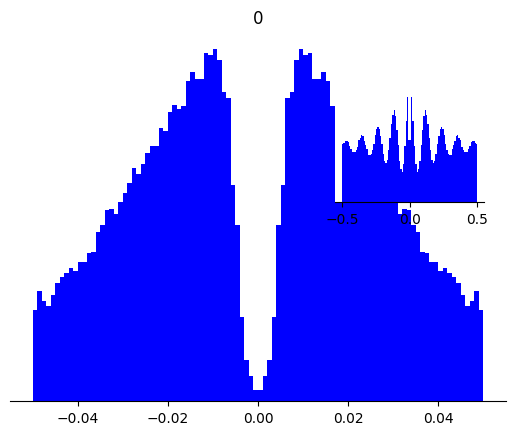

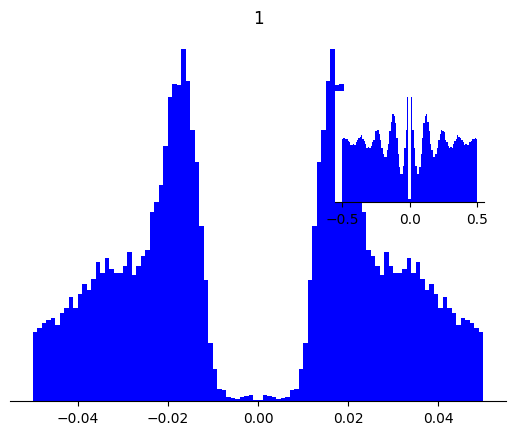

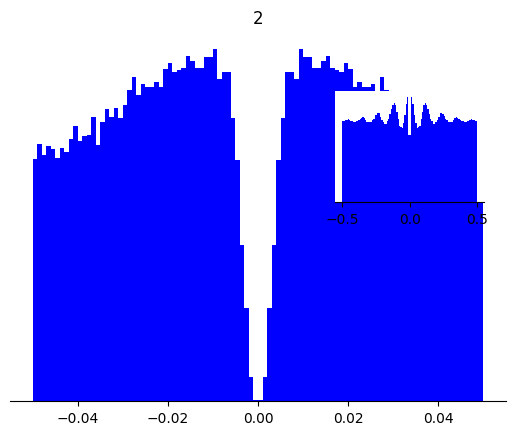

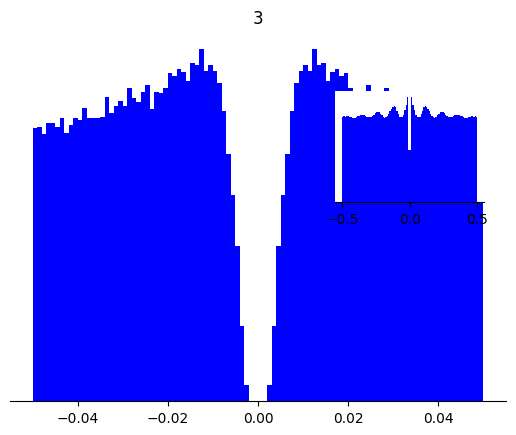

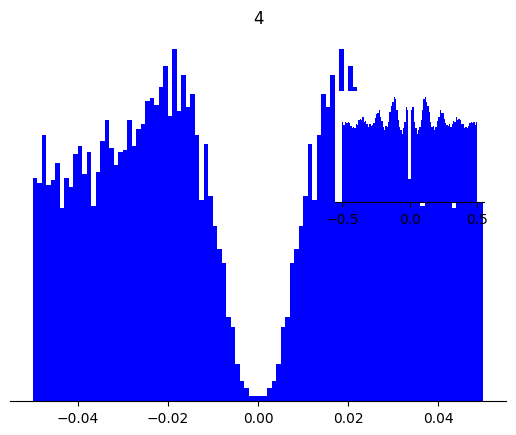

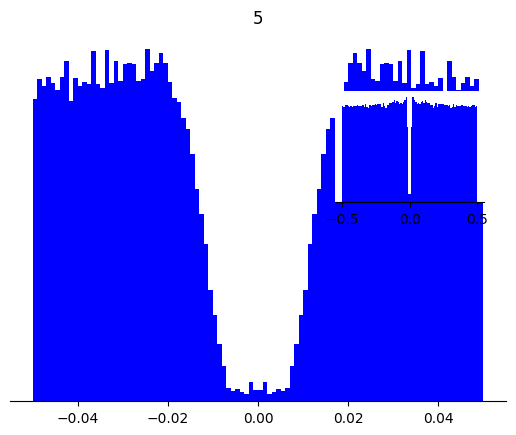

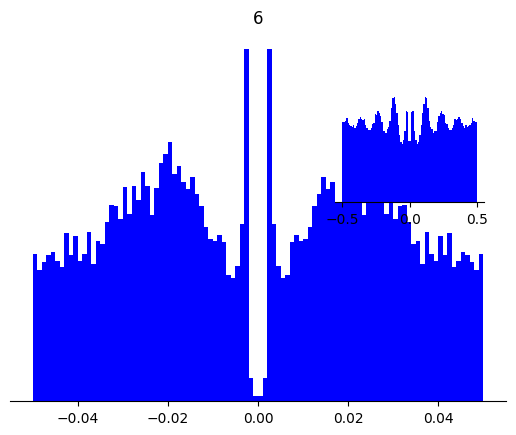

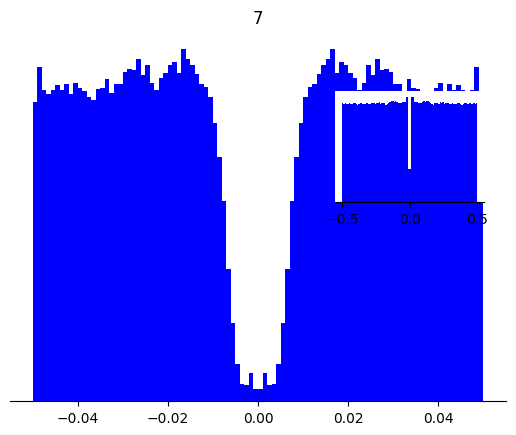

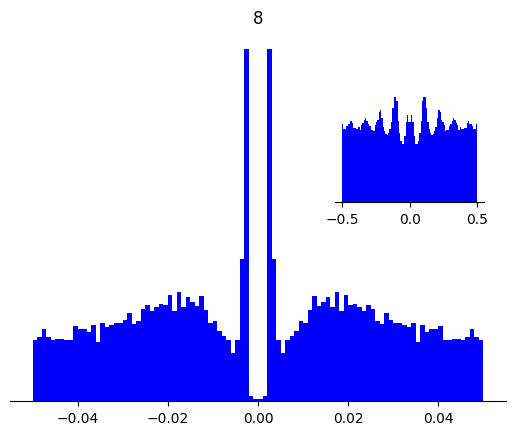

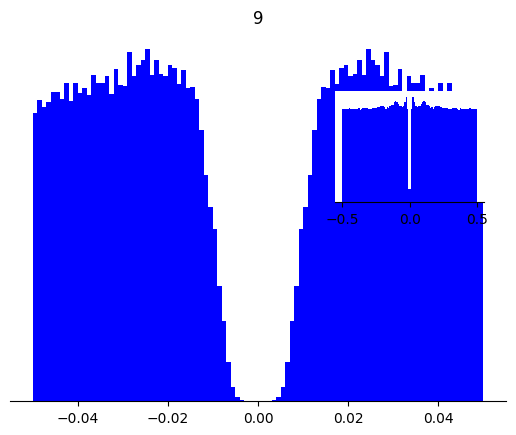

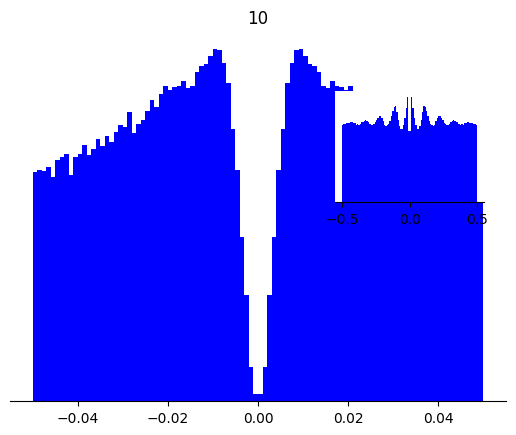

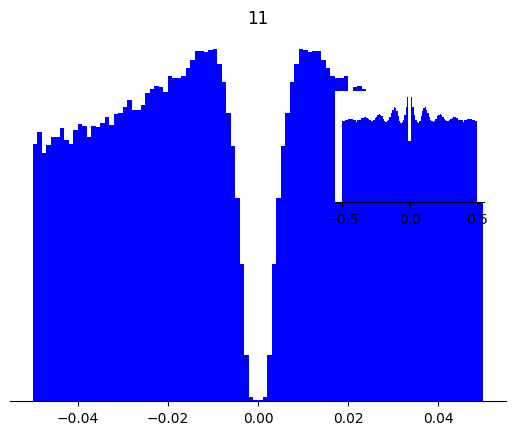

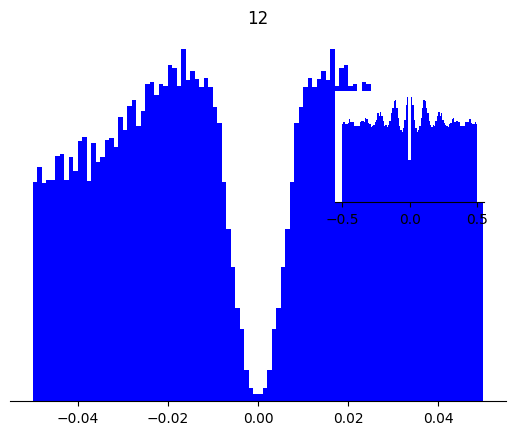

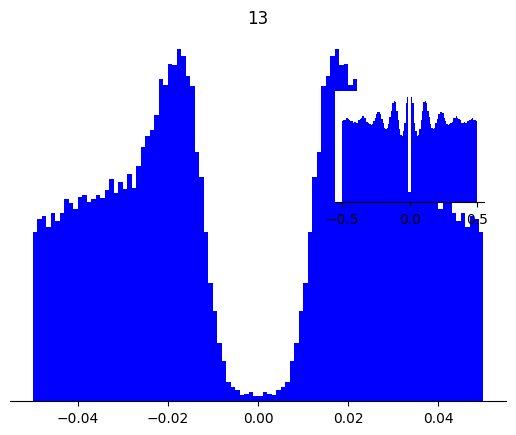

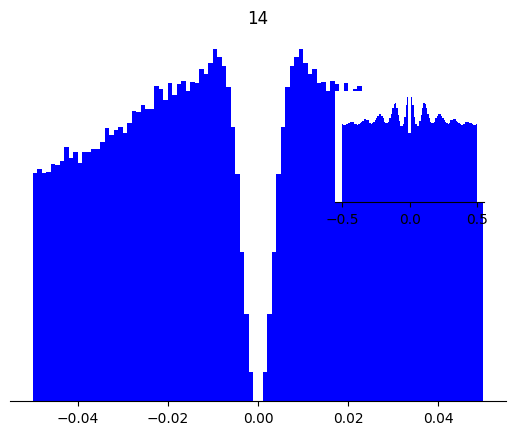

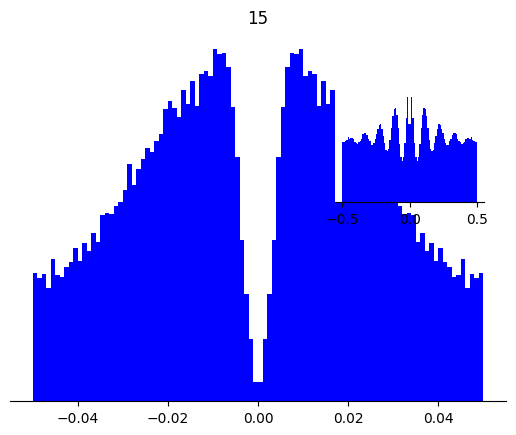

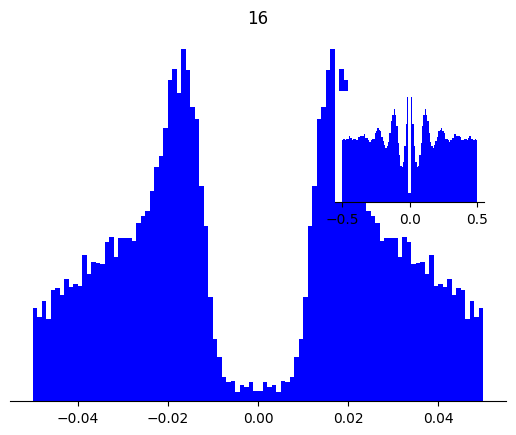

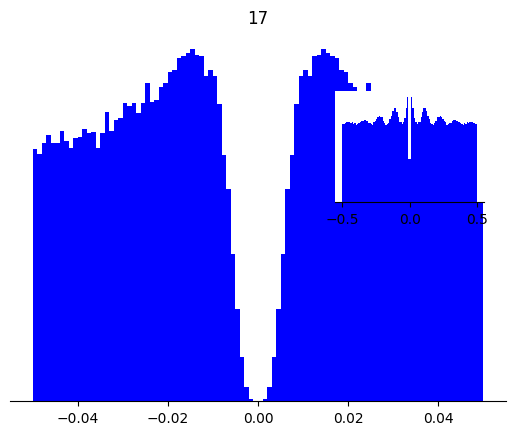

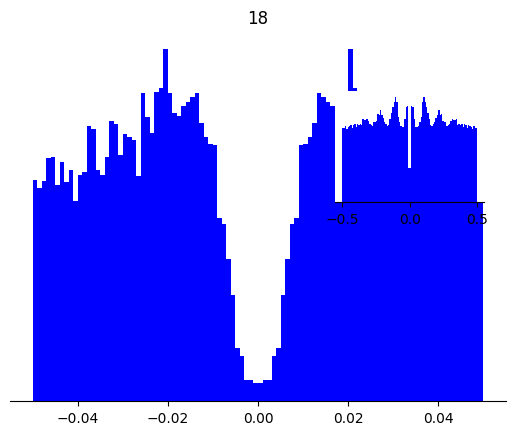

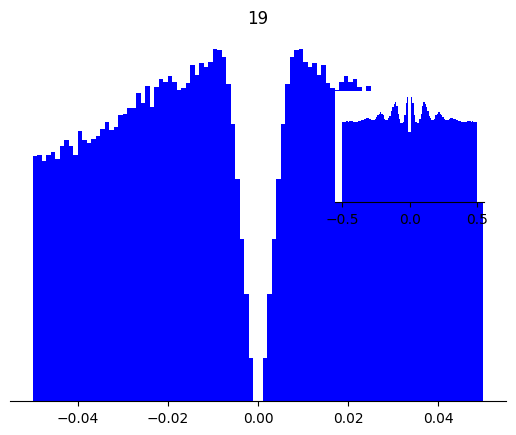

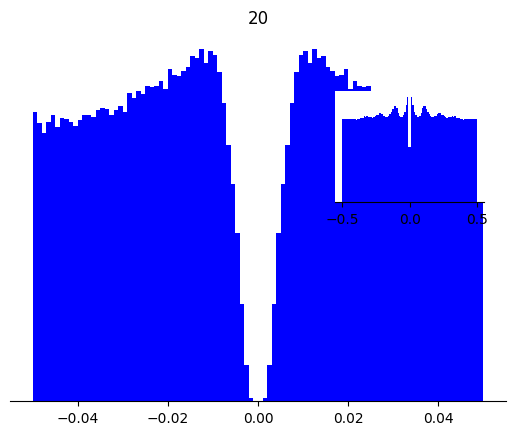

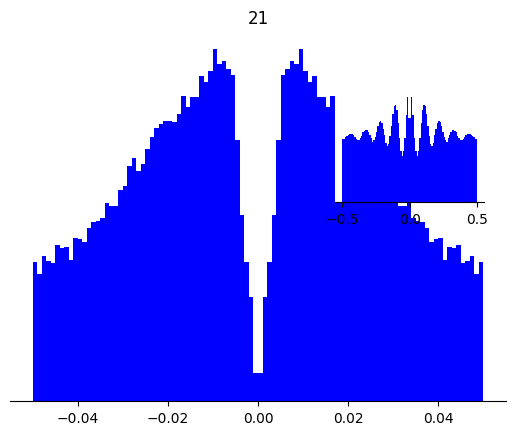

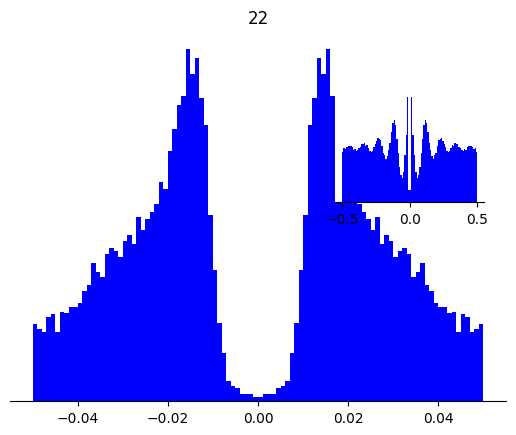

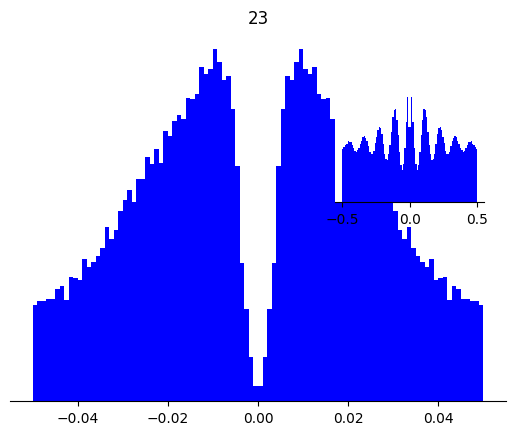

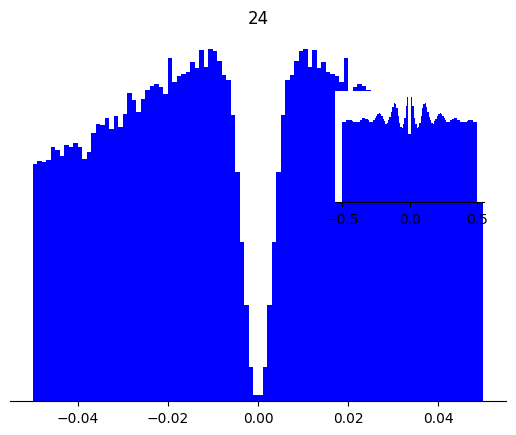

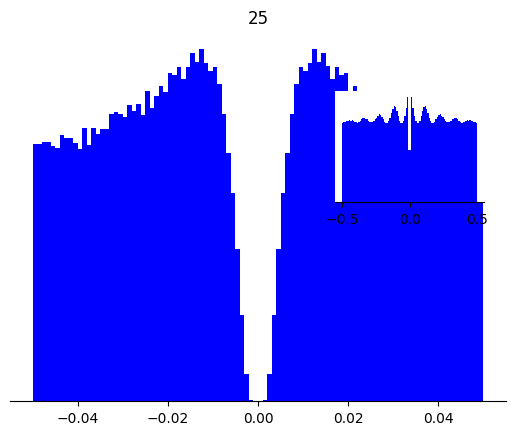

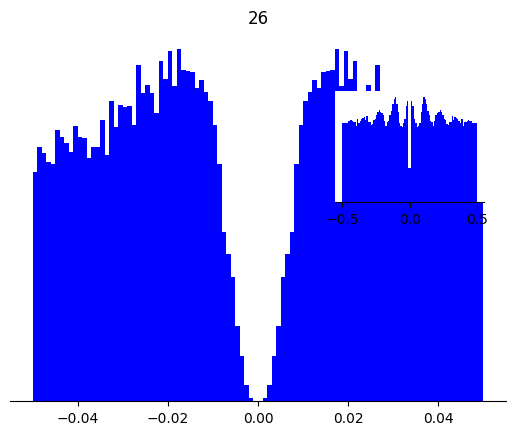

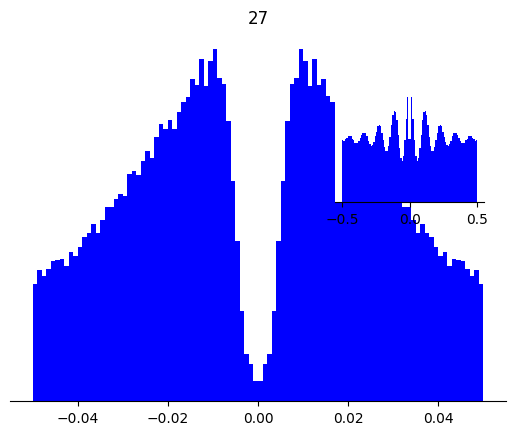

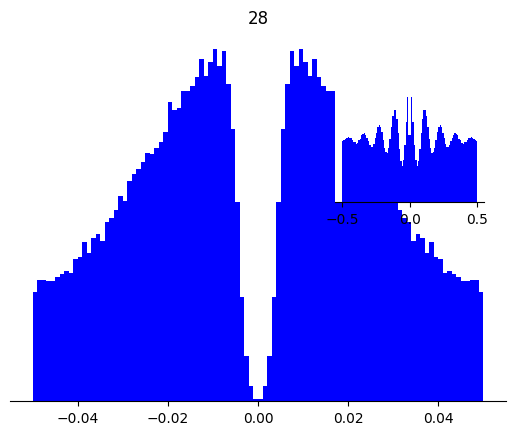

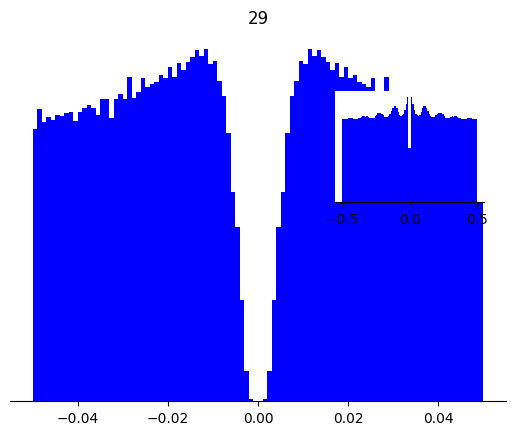

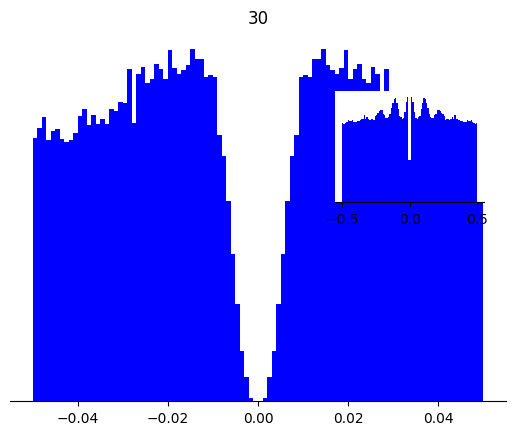

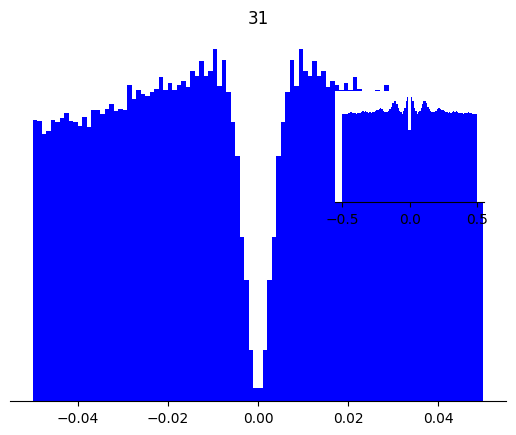

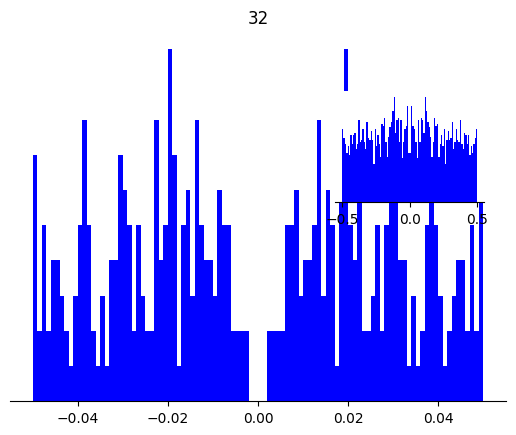

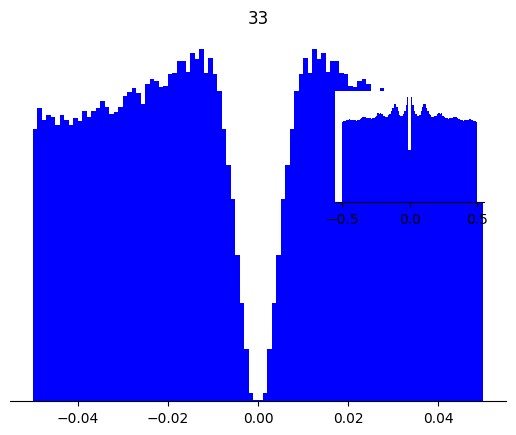

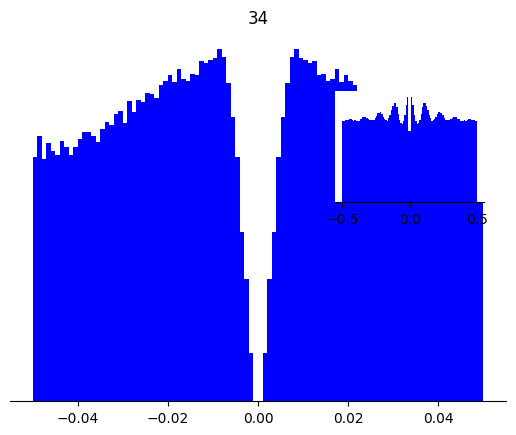

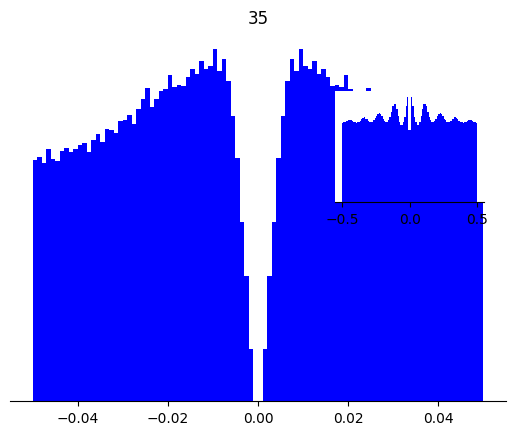

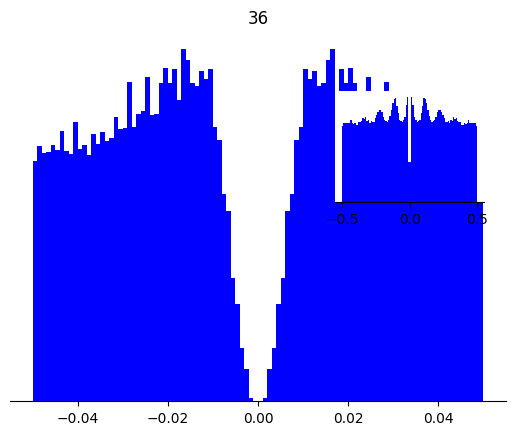

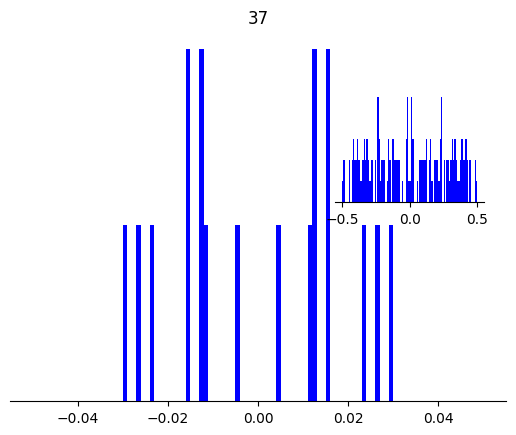

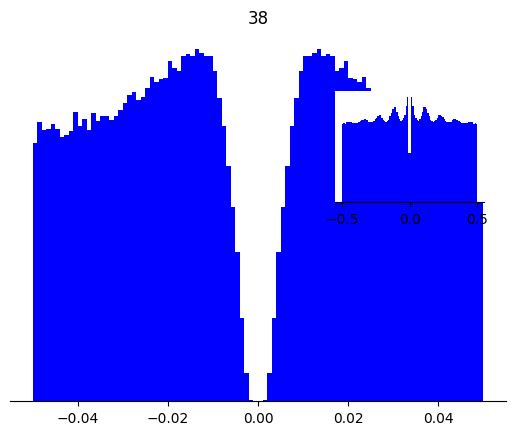

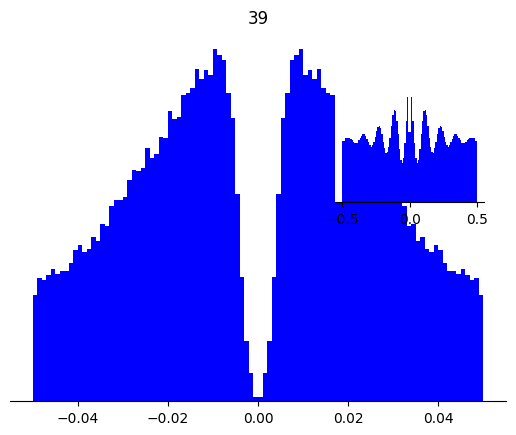

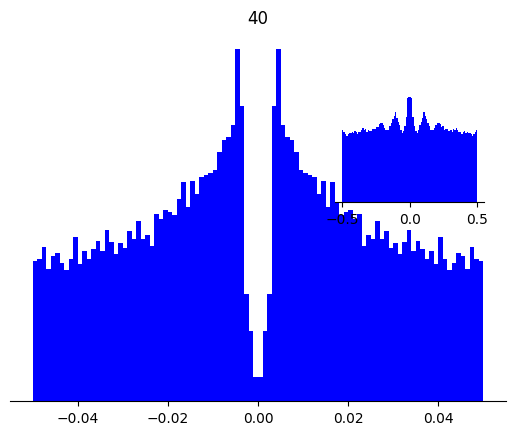

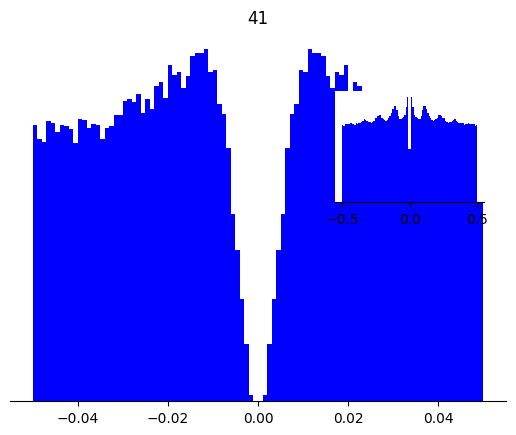

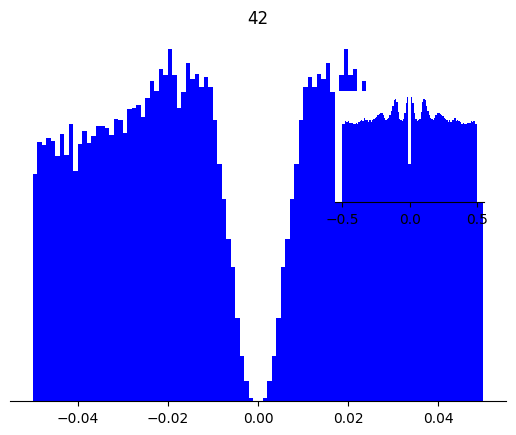

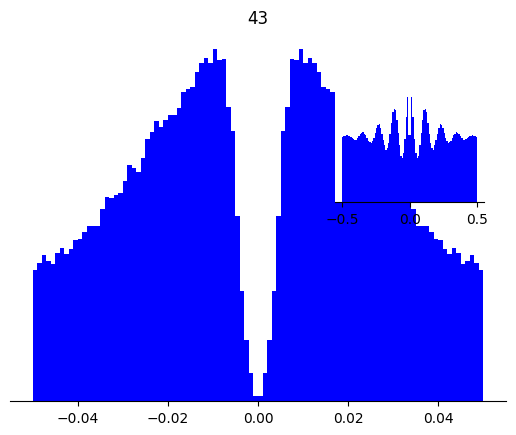

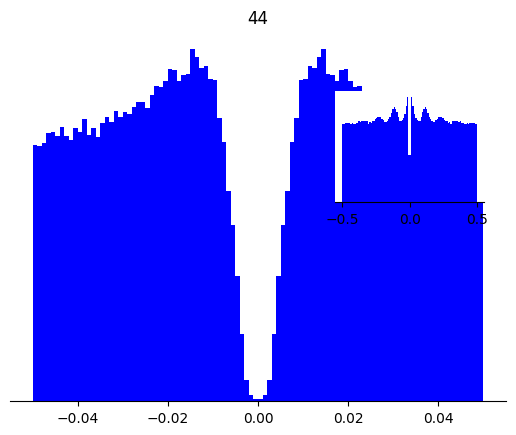

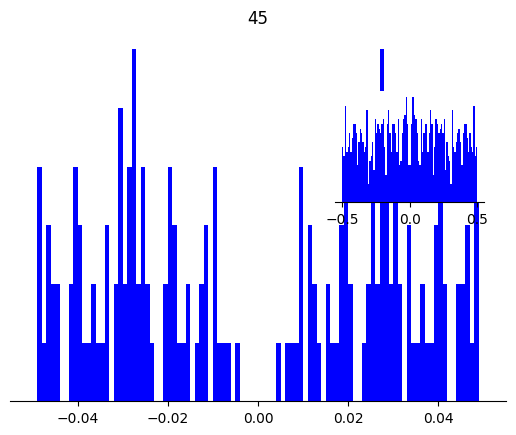

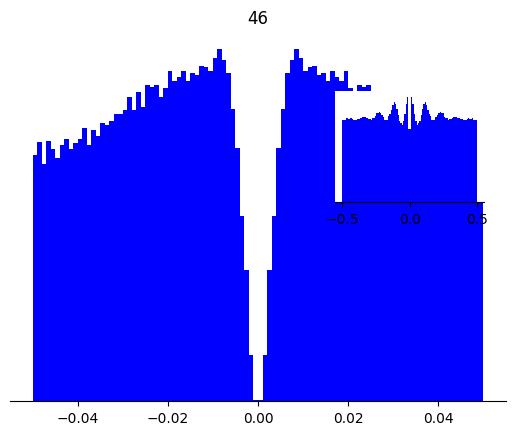

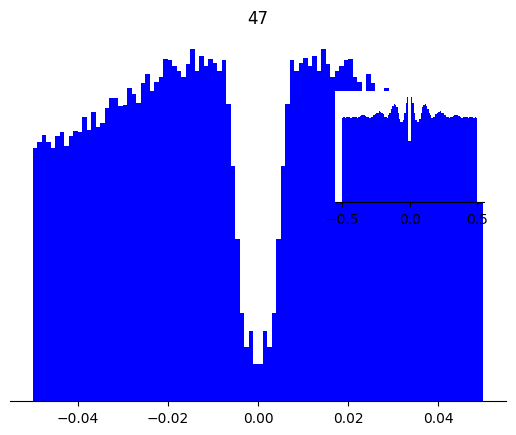

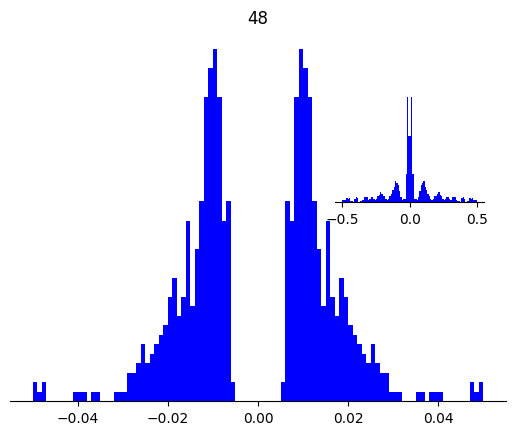

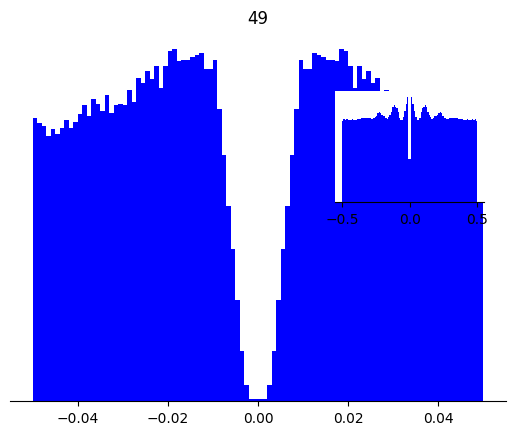

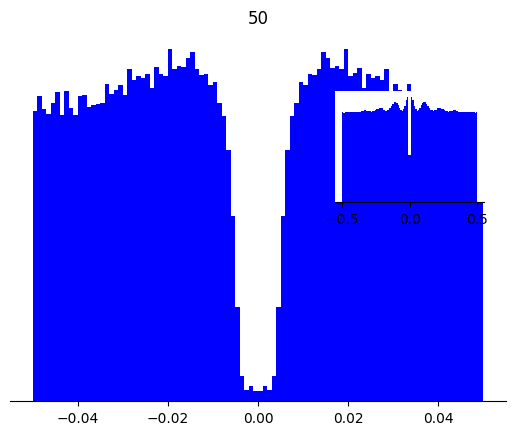

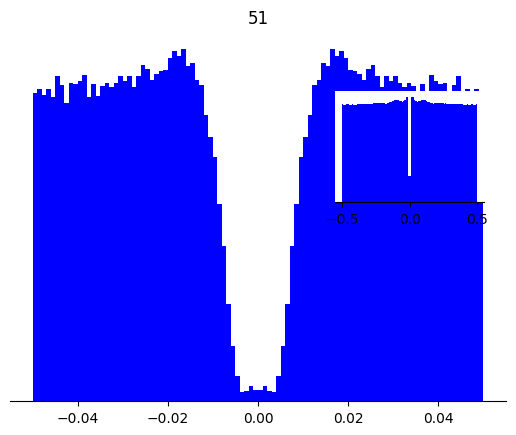

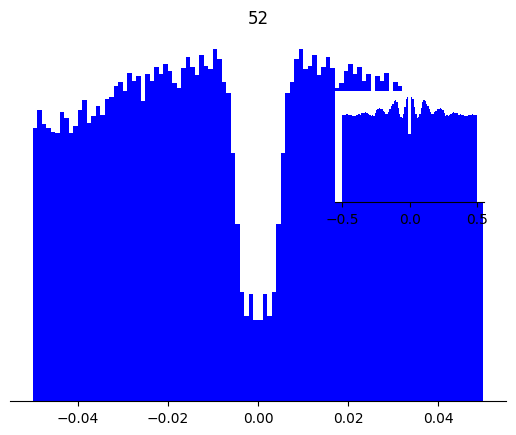

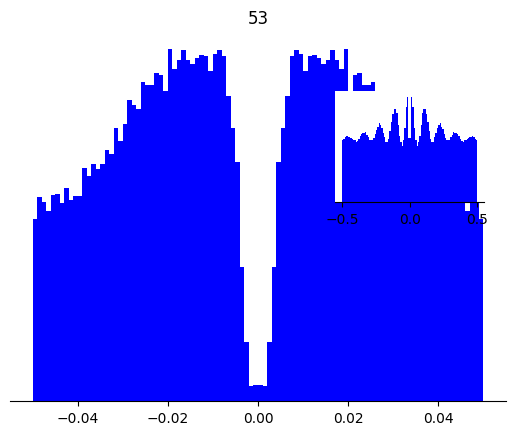

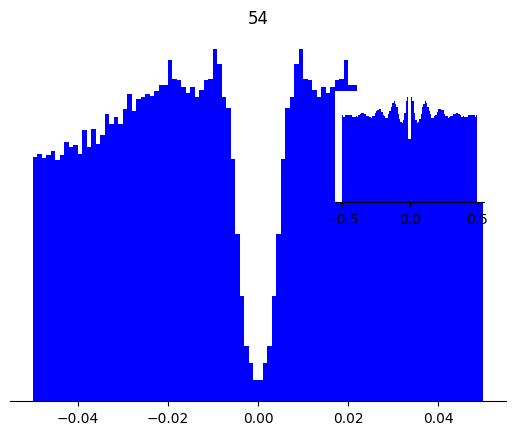

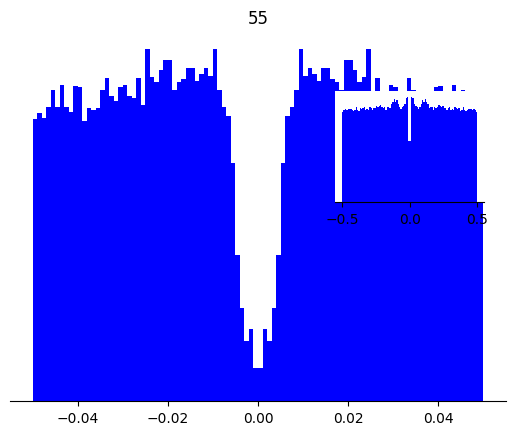

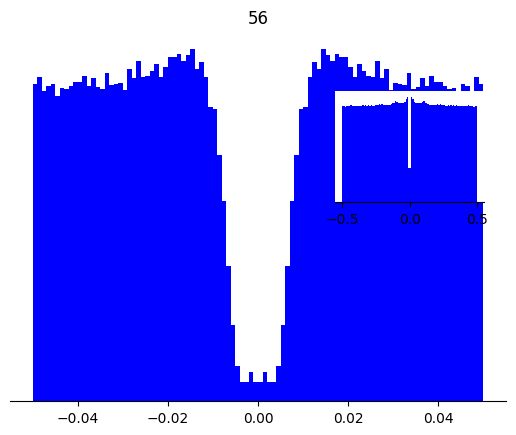

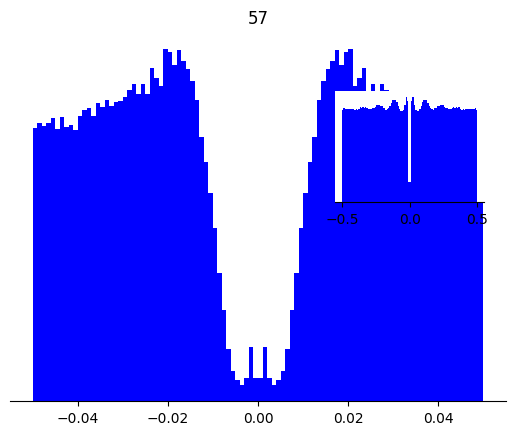

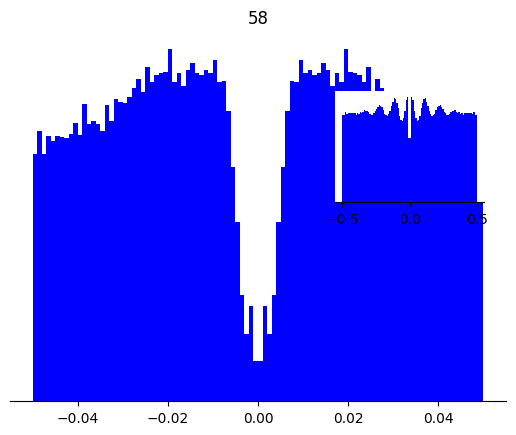

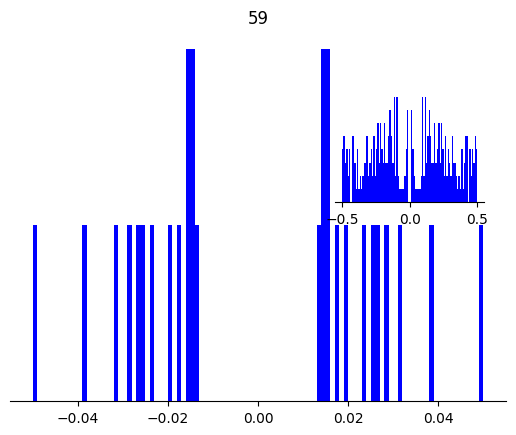

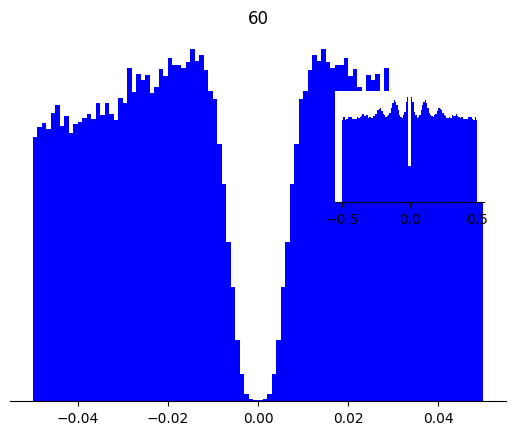

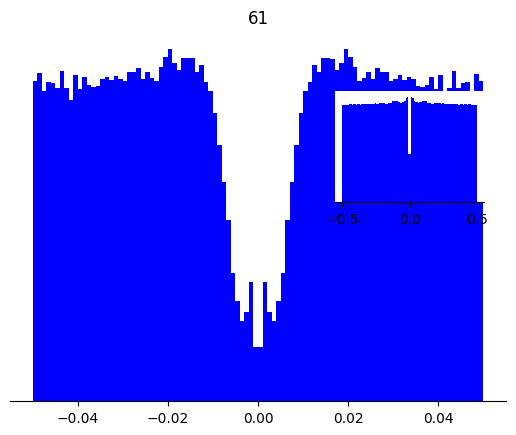

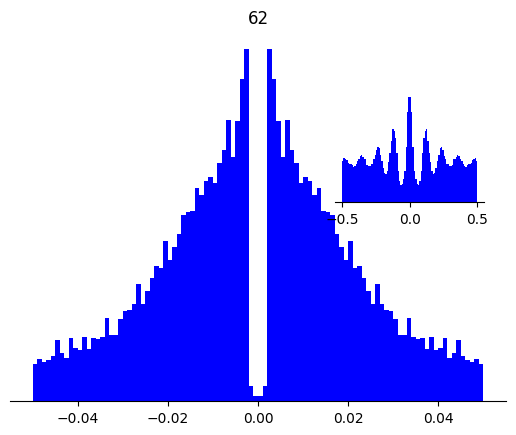

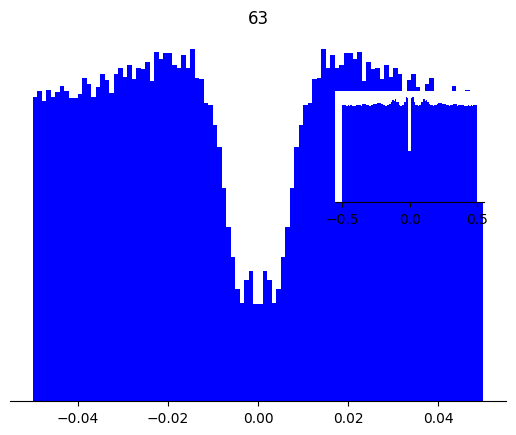

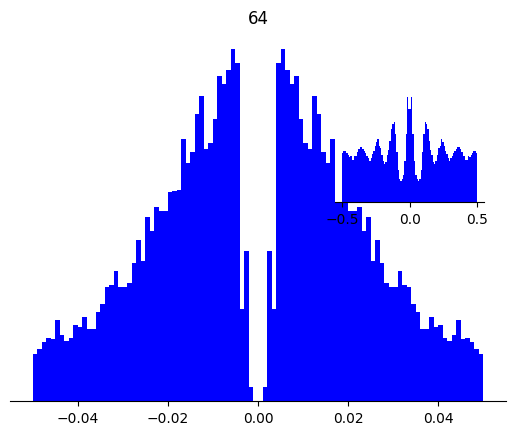

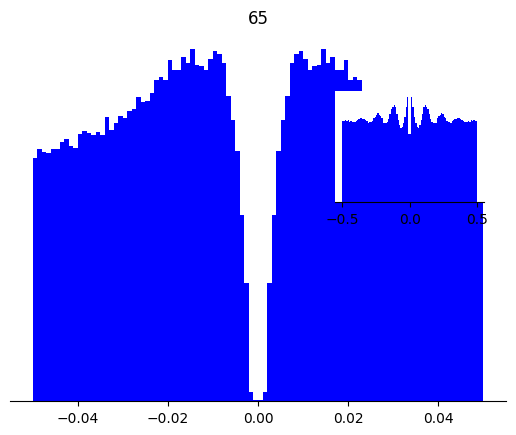

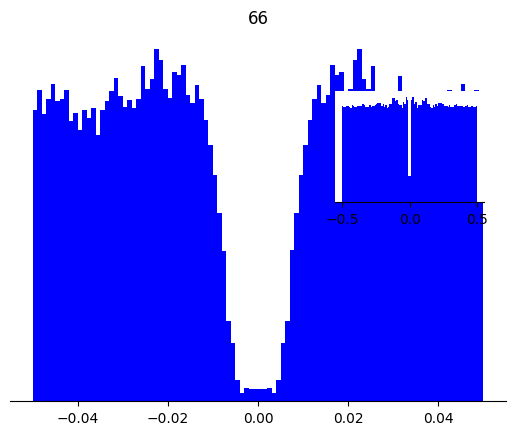

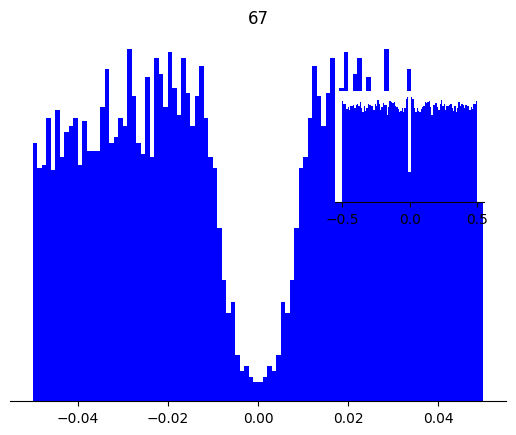

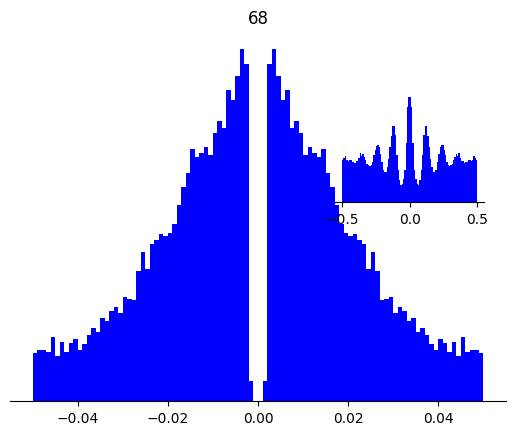

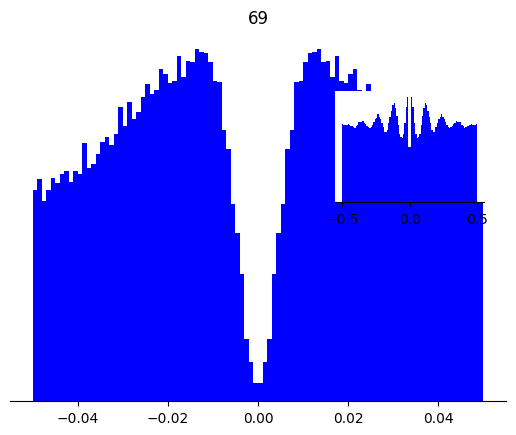

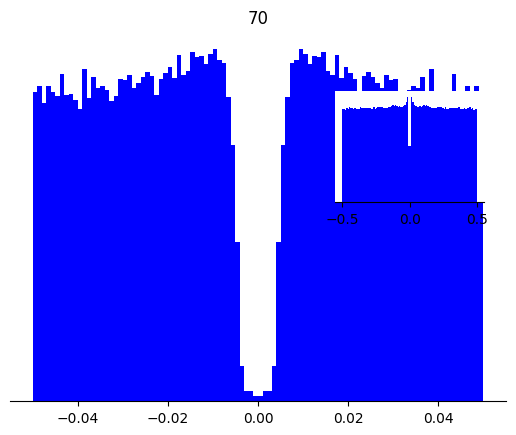

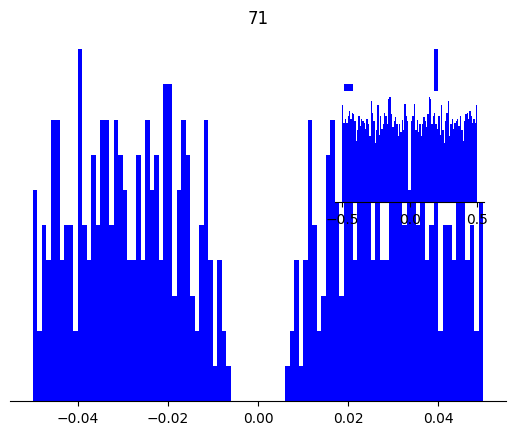

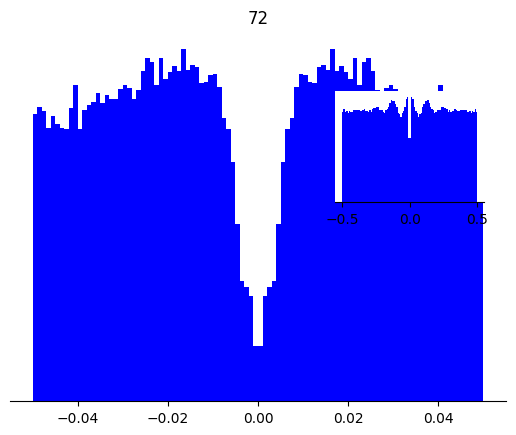

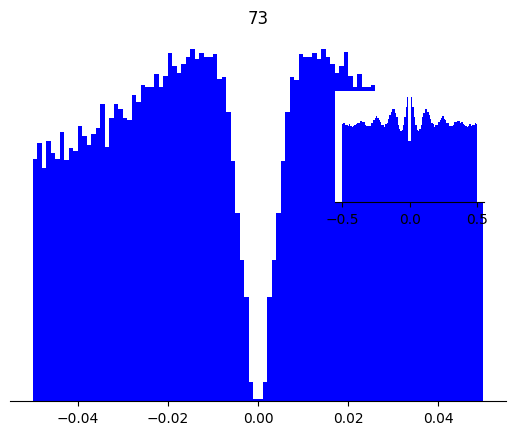

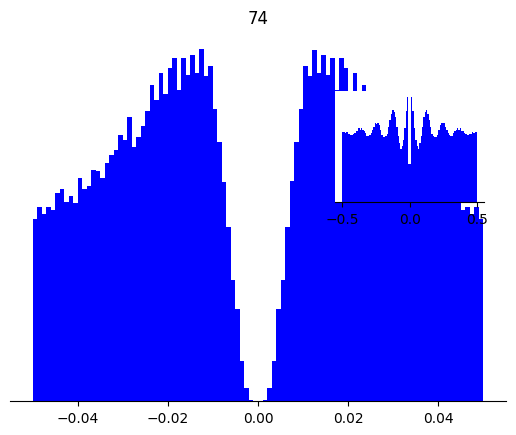

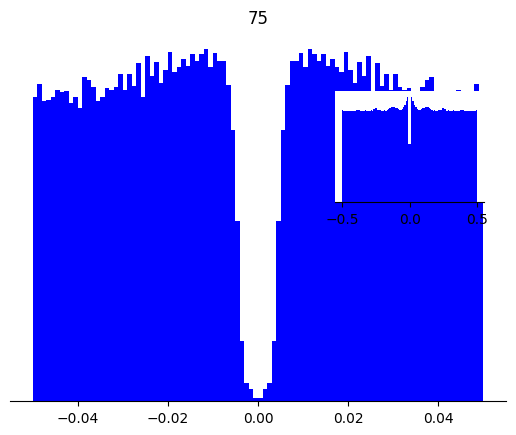

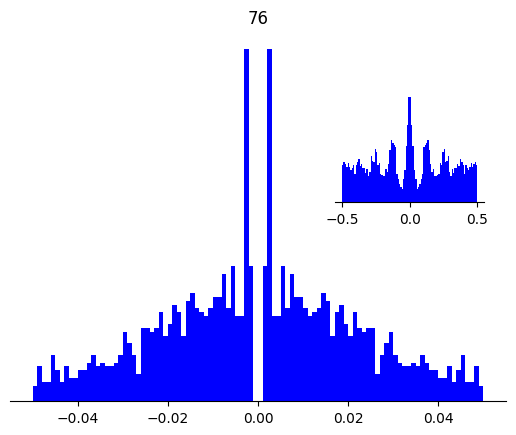

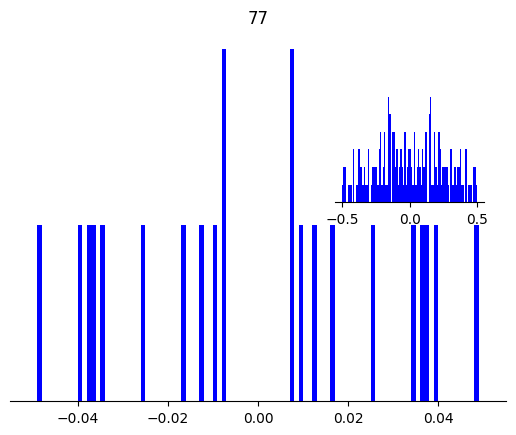

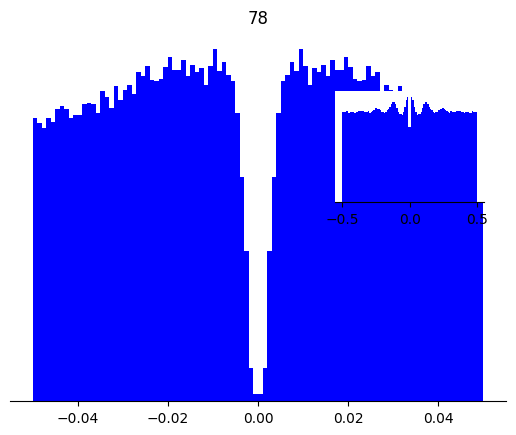

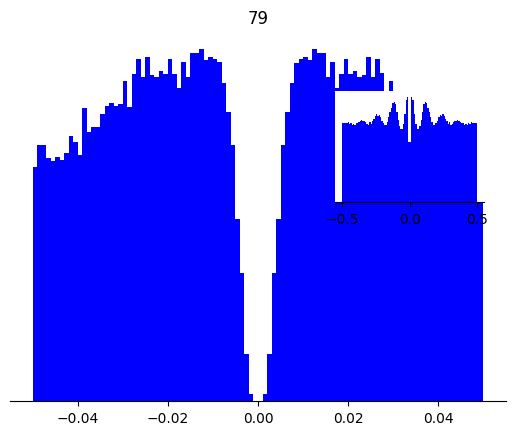

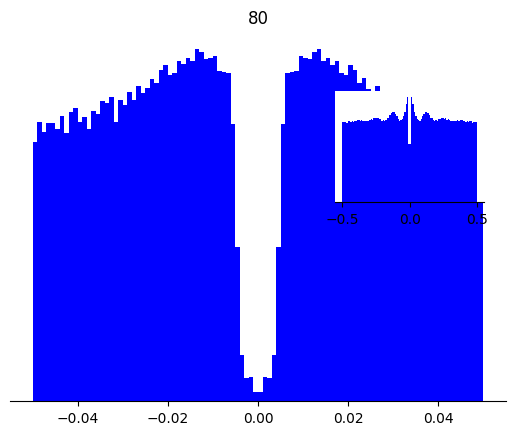

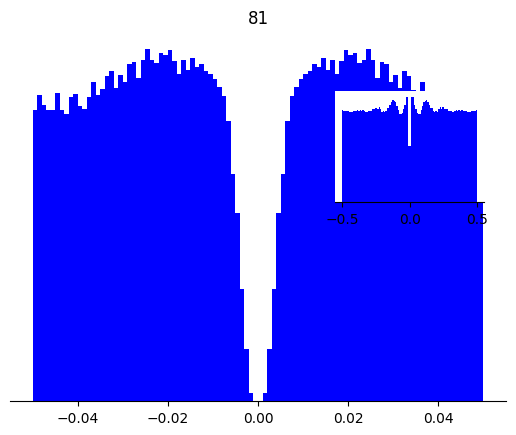

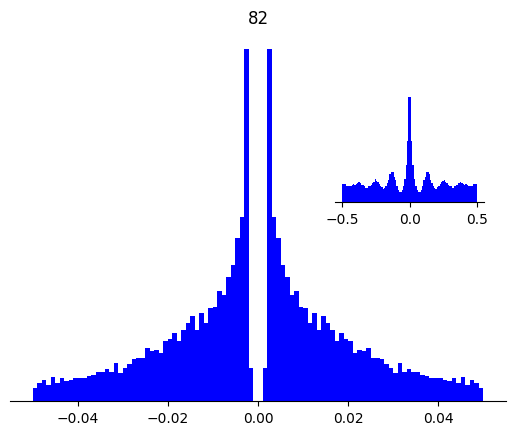

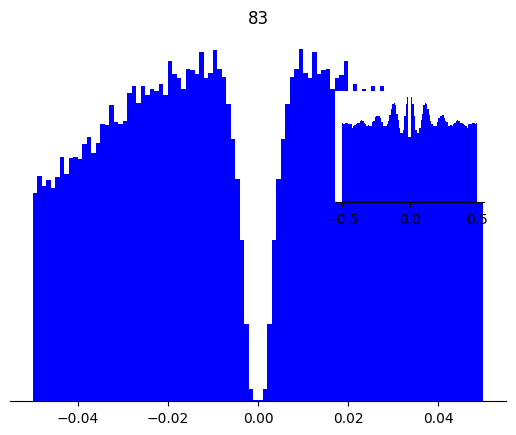

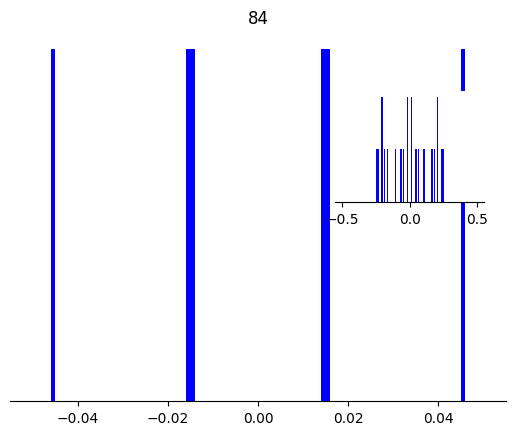

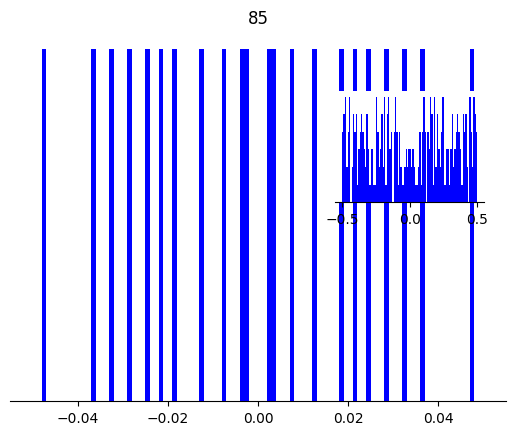

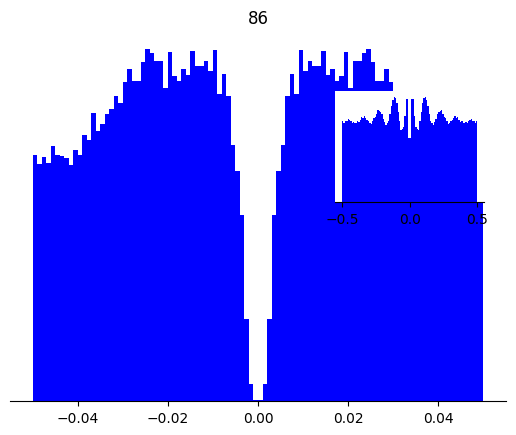

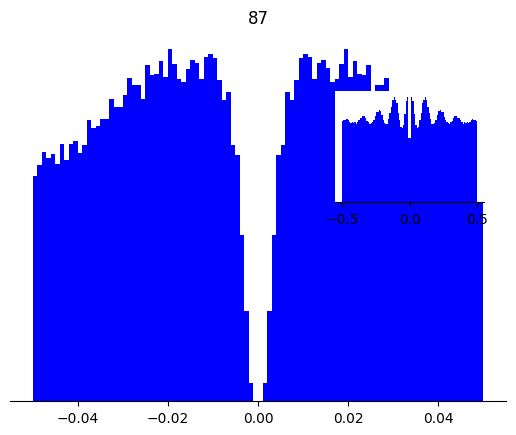

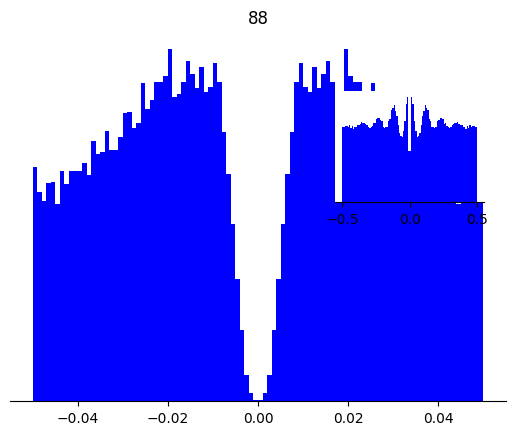

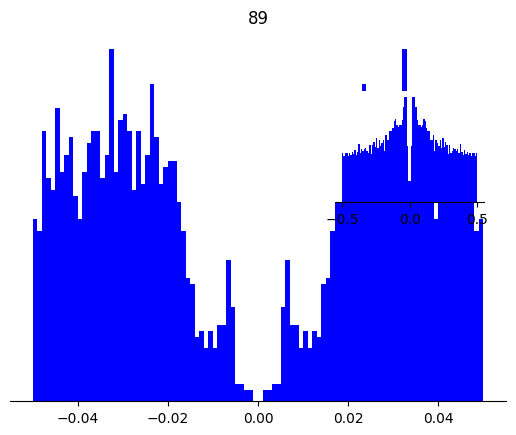

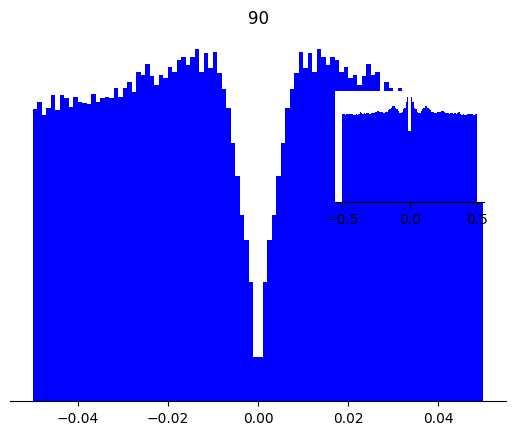

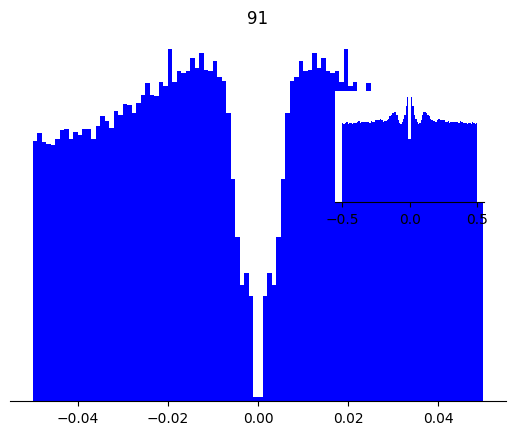

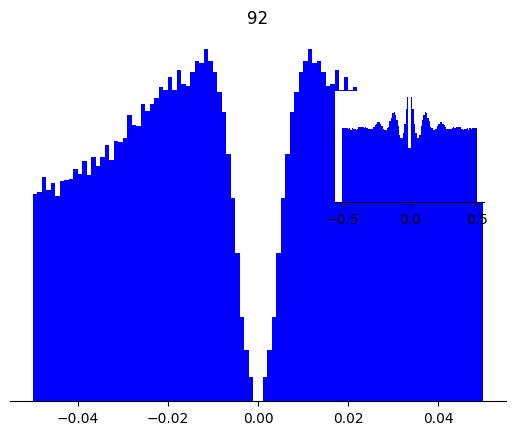

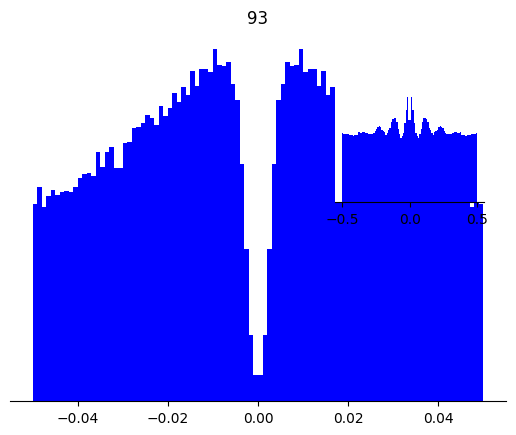

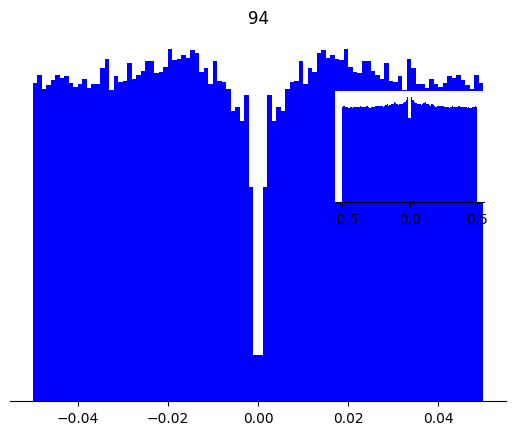

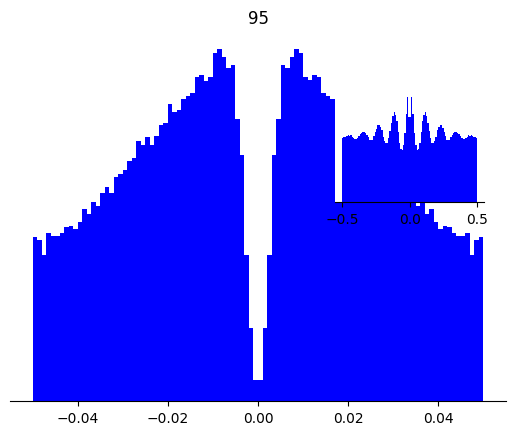

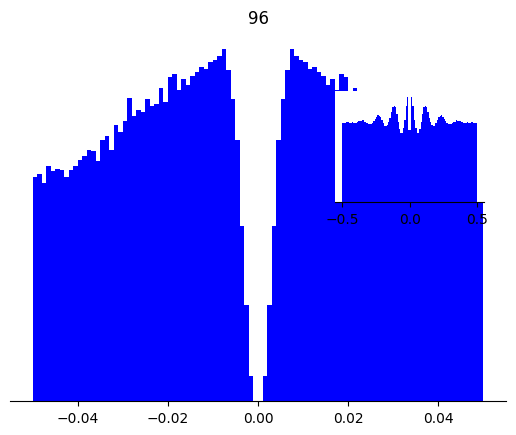

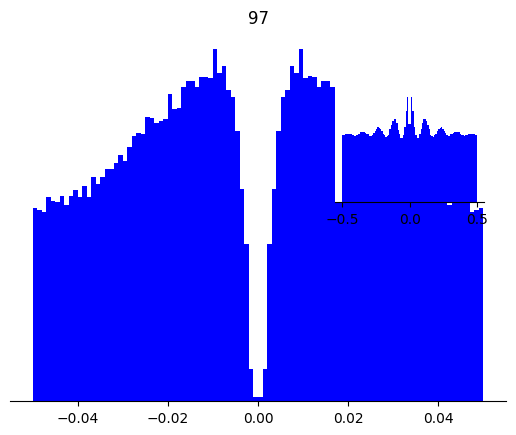

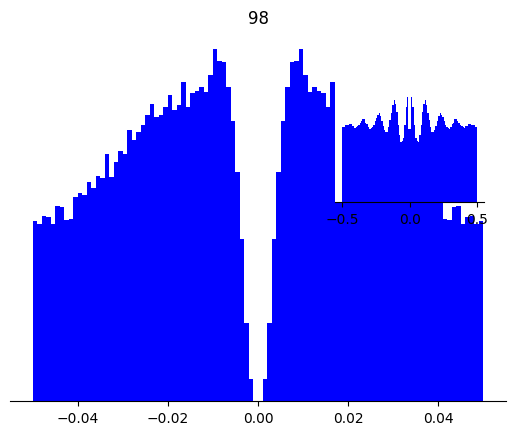

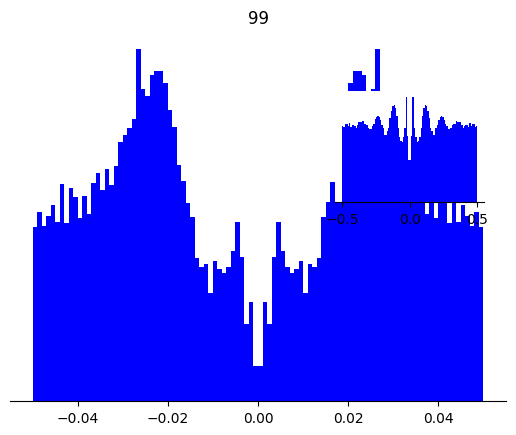

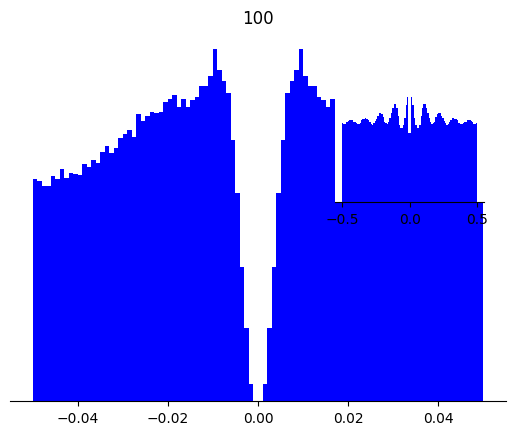

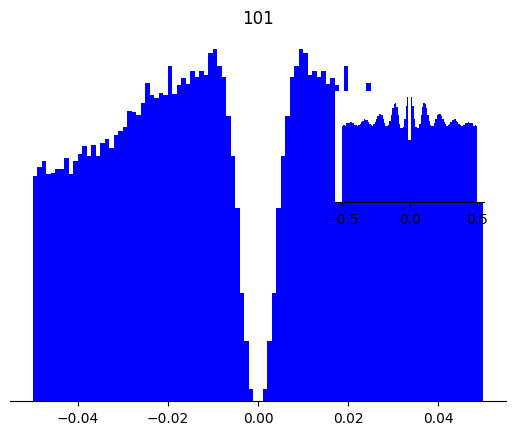

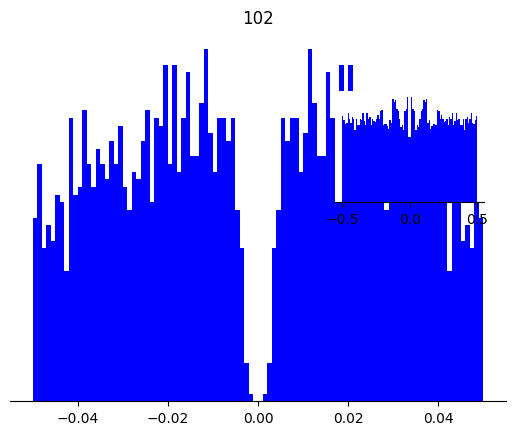

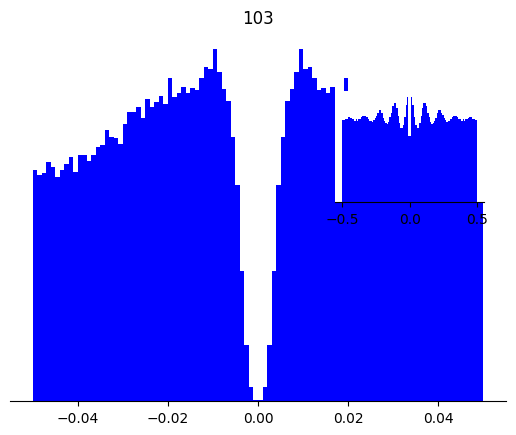

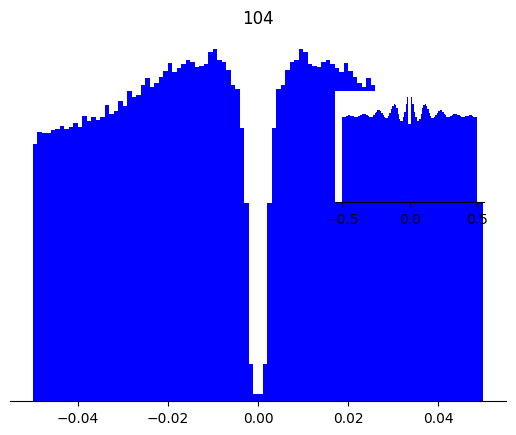

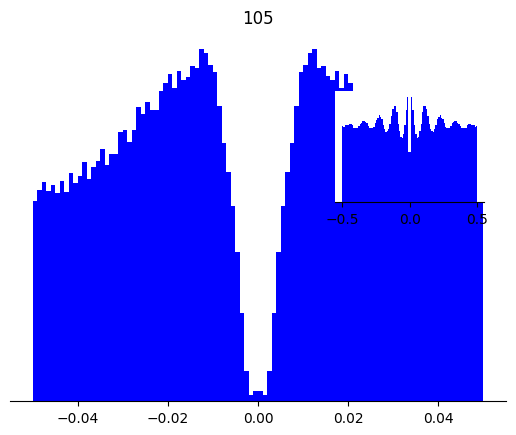

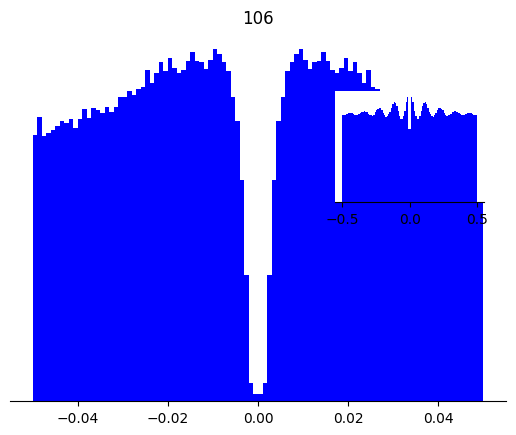

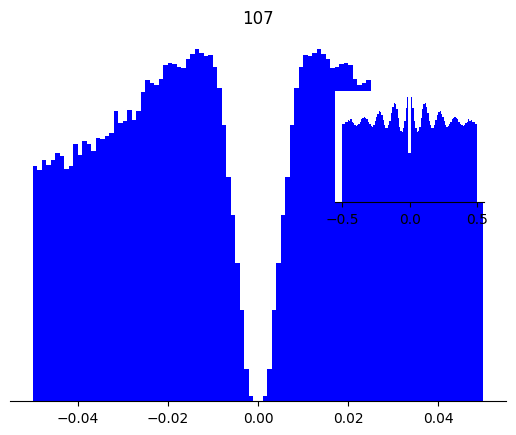

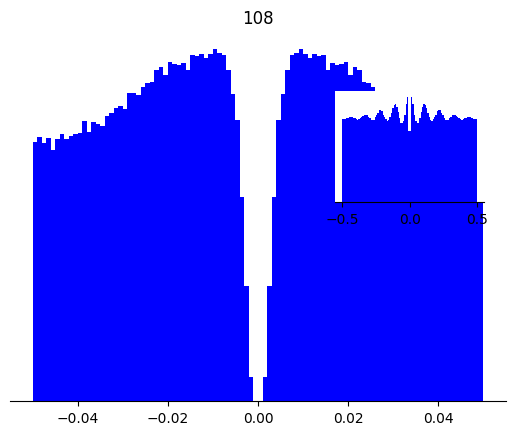

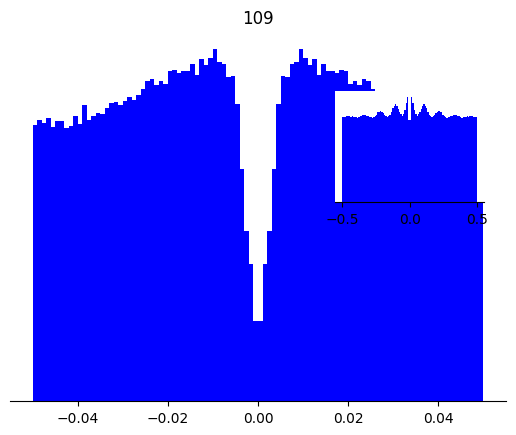

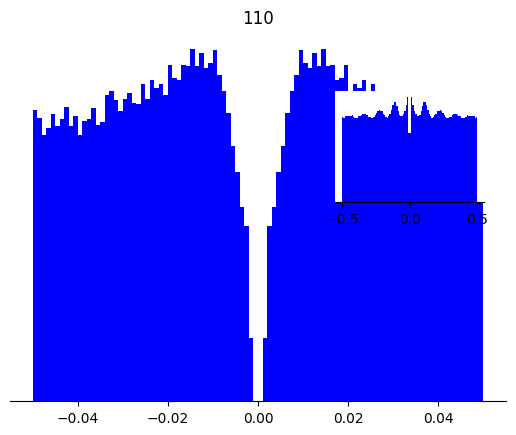

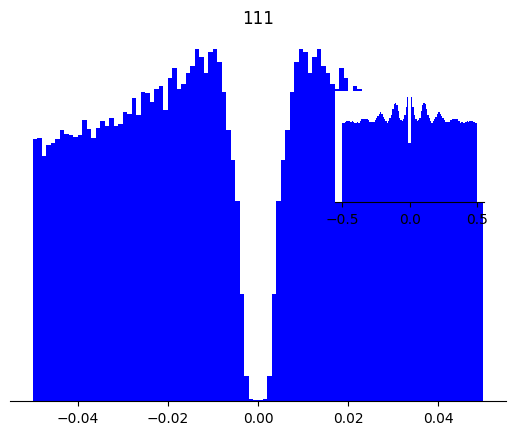

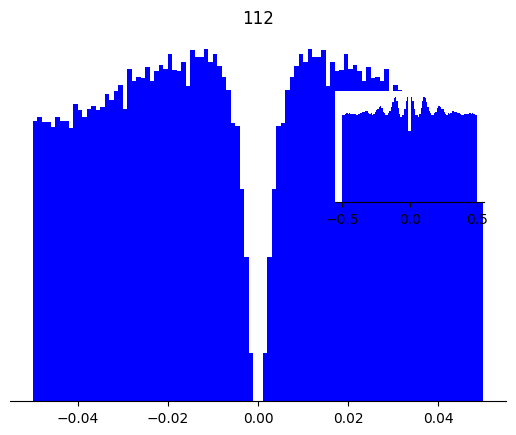

In [3]:
# i=0
# bin_size=0.001
# max_lag=0.1

# for spk in control_pyramidal['spike_times']:
#     i += 1
#     fig = plt.figure()
#     ax_2d = fig.add_subplot(111)
#     a,bin_edges  = calculate_burst_index(spk, bin_size=0.001, max_lag=0.1)
#     # Compute bin centers for plotting
    
#     # Plot the bar chart using bin centers
#     ax_2d.bar(bin_edges[:-1], a, width=bin_size)
#     ax_2d.set_title(f"Spike Train {i}")

### control example 113

i=0

#spk4example_con = control_pyramidal['spike_times'].iloc[112]
for spk4example_con in control_interneuron['spike_times']:
#spk4example_con =control_pyramidal['spike_times'].iloc[114]

    fig=plt.figure()
    ax=fig.add_subplot(111)
    bin_size=0.001
    max_lag=0.05
    a,bin_edges  = calculate_burst_index(spk4example_con, bin_size=bin_size, max_lag=max_lag)
    # Compute bin centers for plotting

    # Plot the bar chart using bin centers
    ax.stairs(a,bin_edges, fill=True, facecolor="blue")
    ax.legend().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.set_title(i)
    inset_ax_sup = inset_axes(ax, width="100%", height="100%", loc='lower right',
                    bbox_to_anchor=(0.67, 0.52, 0.3, 0.3),  # 4-tuple: x0, y0, width, height
                    bbox_transform= ax.transAxes)

    bin_size=0.01
    max_lag=0.5
    a,bin_edges  = calculate_burst_index(spk4example_con, bin_size=bin_size, max_lag=max_lag)

    inset_ax_sup.stairs(a,bin_edges, fill=True, facecolor="blue")
    inset_ax_sup.legend().set_visible(False)
    inset_ax_sup.spines['top'].set_visible(False)
    inset_ax_sup.spines['right'].set_visible(False)
    inset_ax_sup.spines['left'].set_visible(False)
    inset_ax_sup.set_yticks([])
    i += 1

In [3]:
spk4example_con = control_interneuron['spike_times'].iloc[2]
spk4example_exp = exp_interneuron['spike_times'].iloc[2]

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# --- 2D Static Plot ---
fig = plt.figure(figsize=(7.2, 10),dpi=1200)
ax_2d = fig.add_subplot(421)
plt.rcParams.update({'font.size': 8,'font.family': 'DejaVu Sans'})
linewidth=1
dot_size=2
scale_transefer = 1000

# Plot with specified colors (2D projection)
ax_2d.scatter(control_pyramidal['peak_to_valley']*scale_transefer,control_pyramidal['mean_firing_rate'], c='black', s=dot_size, label='Control Pyramidal')
ax_2d.scatter(control_interneuron['peak_to_valley']*scale_transefer,control_interneuron['mean_firing_rate'],  c='cyan', s=dot_size, label='Exp Pyramidal')
ax_2d.scatter(exp_pyramidal['peak_to_valley']*scale_transefer, exp_pyramidal['mean_firing_rate'],c='black', s=dot_size, label='Control Interneuron')
ax_2d.scatter(exp_interneuron['peak_to_valley']*scale_transefer,exp_interneuron['mean_firing_rate'], c='magenta', s=dot_size, label='Exp Interneuron')
ax_2d.spines['top'].set_visible(False)
ax_2d.spines['right'].set_visible(False)
ax_2d.set_xlabel("Valley to peak (ms)")
ax_2d.set_ylabel("Firing rates (Hz)")
ax_2d.set_xlim(0,1)
ax_2d.set_ylim(0,60)


# Create sample data for plotting
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = x**2
y4 = np.exp(x/10)
# Row 2: Two subplots side by side
ax2_1 = fig.add_subplot(843)
ax2_1.plot(median_control_interneuron, linewidth=linewidth, color='darkblue')
for wave in control_interneuron['normalized_waveform']:
    plt.plot(wave, color="cyan", alpha=0.01)

#plt.plot(median_exp_pyramidal, linewidth=2, color='darkcyan')
ax2_1.axis('off')  # Remove axes
plt.ylim(-1.5625, 0.9375)


ax_3_1 = fig.add_subplot(844)

bin_size=0.001
max_lag=0.05
con_example,bin_edges  = calculate_burst_index(spk4example_con, bin_size=bin_size, max_lag=max_lag)
# Compute bin centers for plotting

# Plot the bar chart using bin centers
ax_3_1.stairs(con_example,bin_edges, fill=True, facecolor="cyan")
ax_3_1.legend().set_visible(False)
ax_3_1.spines['top'].set_visible(False)
ax_3_1.spines['right'].set_visible(False)
ax_3_1.spines['left'].set_visible(False)
ax_3_1.set_yticks([])
ax_3_1.set_xticks([-0.05, 0, 0.05])
ax_3_1.set_xticklabels(['-50 ms', '0', '50 ms'])

current_ylim = ax_3_1.get_ylim()
ax_3_1.set_ylim(0, current_ylim[1] * 2)
inset_ax_sup = inset_axes(ax_3_1, width="100%", height="100%", loc='lower right',
                    bbox_to_anchor=(0.67, 0.52, 0.3, 0.3),  # 4-tuple: x0, y0, width, height
                    bbox_transform= ax_3_1.transAxes)

bin_size=0.01
max_lag=0.5
con_example,bin_edges  = calculate_burst_index(spk4example_con, bin_size=bin_size, max_lag=max_lag)

inset_ax_sup.stairs(con_example,bin_edges, fill=True, facecolor="cyan")
inset_ax_sup.legend().set_visible(False)
inset_ax_sup.spines['top'].set_visible(False)
inset_ax_sup.spines['right'].set_visible(False)
inset_ax_sup.spines['left'].set_visible(False)
inset_ax_sup.set_yticks([])
inset_ax_sup.tick_params(axis='both', labelsize=3, length=2, width=0.3)
inset_ax_sup.set_xticks([-0.5, 0, 0.5])
inset_ax_sup.set_xticklabels(['-500 ms', '0', '500 ms'])

ax2_2 = fig.add_subplot(847)
ax2_2.plot(median_exp_interneuron, linewidth=linewidth, color='darkred')

for wave in exp_interneuron['normalized_waveform']:
    plt.plot(wave, color="magenta", alpha=0.01)
ax2_2.axis('off')  # Remove axes
plt.ylim(-1.5625, 0.9375)
ax_3_2 = fig.add_subplot(848)
bin_size=0.001
max_lag=0.05
exp_example,bin_edges  = calculate_burst_index(spk4example_exp, bin_size=bin_size, max_lag=max_lag)
# Compute bin centers for plotting

# Plot the bar chart using bin centers
ax_3_2.stairs(exp_example,bin_edges, fill=True, facecolor="magenta")
ax_3_2.legend().set_visible(False)
ax_3_2.spines['top'].set_visible(False)
ax_3_2.spines['right'].set_visible(False)
ax_3_2.spines['left'].set_visible(False)
ax_3_2.set_yticks([])
ax_3_2.set_xticks([-0.05, 0, 0.05])
current_ylim = ax_3_2.get_ylim()
ax_3_2.set_ylim(0, current_ylim[1] * 2)
ax_3_2.set_xticklabels(['-50 ms', '0', '50 ms'])
inset_ax_sup = inset_axes(ax_3_2, width="100%", height="100%", loc='lower right',
                    bbox_to_anchor=(0.67, 0.52, 0.3, 0.3),  # 4-tuple: x0, y0, width, height
                    bbox_transform= ax_3_2.transAxes)
bin_size=0.01
max_lag=0.5
exp_example,bin_edges  = calculate_burst_index(spk4example_exp, bin_size=bin_size, max_lag=max_lag)
inset_ax_sup.stairs(exp_example,bin_edges, fill=True, facecolor="magenta")
inset_ax_sup.legend().set_visible(False)
inset_ax_sup.spines['top'].set_visible(False)
inset_ax_sup.spines['right'].set_visible(False)
inset_ax_sup.spines['left'].set_visible(False)
inset_ax_sup.set_yticks([])
inset_ax_sup.tick_params(axis='both', labelsize=3, length=2, width=0.3)
inset_ax_sup.set_xticks([-0.5, 0, 0.5])
inset_ax_sup.set_xticklabels(['-500 ms', '0', '500 ms'])

axes_violin = [fig.add_subplot(4, 3, i+1+3) for i in range(9)]
# Set global font size to 10.5
# Load Good units
df_loaded = pd.read_pickle(r'Q:/sachuriga/CR_CA1_paper/tables/functional_properties_with_python_measurements.pkl')
df_good = df_loaded[df_loaded['unit_quality'] == "good"]

df_good['buzaki_py_cell_type']=None
for i in range(len(df_good)):
    if (df_good['peak_to_valley'].iloc[i] <= 0.000425):
        df_good['buzaki_py_cell_type'].iloc[i] = "narrow_spike_interneurons"
    elif (df_good['mean_firing_rate'].iloc[i] >= 10):
        if df_good['peak_to_valley'].iloc[i] <= 0.000425:
            df_good['buzaki_py_cell_type'].iloc[i] = "narrow_spike_interneurons"
        else:
            df_good['buzaki_py_cell_type'].iloc[i] = "wide_spike_interneurons"

    #elif  (df_good['peak_to_valley'].iloc[i] > 0.000425) & (((df_good['tau_rise_python'].iloc[i]) + (df_good['acg_first_positive_x'].iloc[i])) >= 6):
    elif  (df_good['peak_to_valley'].iloc[i] > 0.000425) & ((df_good['tau_rise_python'].iloc[i])  >= 6):
        df_good['buzaki_py_cell_type'].iloc[i] = "wide_spike_interneurons"
    #elif (df_good['peak_to_valley'].iloc[i] > 0.000425) & (df_good['mean_firing_rate'].iloc[i] < 10) & (((df_good['tau_rise_python'].iloc[i]) + (df_good['acg_first_positive_x'].iloc[i])) < 6):
    elif (df_good['peak_to_valley'].iloc[i] > 0.000425) & (df_good['mean_firing_rate'].iloc[i] < 10) & ((df_good['tau_rise_python'].iloc[i])  < 6):
        df_good['buzaki_py_cell_type'].iloc[i] = "pyramidal"


df_py = df_good[df_good['buzaki_py_cell_type'] == "narrow_spike_interneurons"]
funct = [""]
for functional_plot in funct:
    if functional_plot:
        df = df_py[df_py['functional_cell_type'] == "Place cell"]
    else:
        df = df_py

    base_folder = r"Q:/sachuriga/CR_CA1_paper/Results/cell_type"

    control_ids = ['65165', '65091', '63383', '66539', '65622']
    exp_ids = ['65588', '63385', '66538', '66537', '66922']

    session = ["A"]

    for session in session:
        if session == "Total":
            df_a = df
        else:
            df_a = df[df['session'] == session]

        control_df = df_a[df_a['animal_id'].isin(control_ids)]
        exp_df = df_a[df_a['animal_id'].isin(exp_ids)]

        sns.set_theme(style="ticks")

        metrics = ['amplitude_median','half_width','peak_to_valley','peak_trough_ratio', 'recovery_slope', 'repolarization_slope', 
                  'mean_firing_rate',  'mean_inter_spike_interval','bursting_index' ]
        
        titles = ['Amplitude median (mV)', 'Half width (ms)', 'Peak to valley (ms)', 
                  'peak trough ratio', 'Recovery slope', 
                  'Repolarization slope','Firing rate (Hz)', 'Mean inter spike interval (ms)', 'Bursting index']
        
        # Define x-axis limits: (lower, upper), None for full auto, or (fixed, None)/(None, fixed) for one-sided
        xlim_dict = {
            'half_width': (None, 0.3),              # Upper fixed, lower auto
            'recovery_slope': (None, None),     # Lower fixed, upper auto
            'repolarization_slope': None,     # Full auto
            'mean_firing_rate': (None, None),       # Upper fixed, lower auto
            'peak_trough_ratio': (None, None), # Full auto
            'peak_to_valley': None,           # Full auto
            'bursting_index': (-1, 1),         # Upper fixed, lower auto
            'mean_inter_spike_interval': (0.1, 1), # Lower fixed, upper auto
            'amplitude_median': None,          # Full auto
            'mode_inter_spike_interval': (0,0.02)
        }
        scale_transefers = [0.001,1000,1000,1,0.00001,0.000001,1,1,1]
        control_color = "cyan"
        exp_color = "magenta"

        for idx, metric in enumerate(metrics):
            control_values = control_df[metric].dropna() *scale_transefers[idx]
            exp_values = exp_df[metric].dropna()*scale_transefers[idx]

            if len(control_values) > 0 and len(exp_values) > 0:
                control_mean = control_values.mean()
                exp_mean = exp_values.mean()
                control_sem = control_values.sem()
                exp_sem = exp_values.sem()

                print(f"\nComparison for {metric} (Session {session}):")
                print(f"Control mean: {control_mean:.2f} ± {control_sem:.2f}")
                print(f"Experimental mean: {exp_mean:.2f} ± {exp_sem:.2f}")

                # Original statistical tests for violin plot
                control_ks_stat, control_ks_p = stats.kstest(control_values, 'norm', 
                                                             args=(control_mean, control_values.std()))
                exp_ks_stat, exp_ks_p = stats.kstest(exp_values, 'norm', 
                                                     args=(exp_mean, exp_values.std()))
                normal = control_ks_p > 0.05 and exp_ks_p > 0.05

                levene_stat, levene_p = stats.levene(control_values, exp_values)
                homoscedastic = levene_p > 0.05

                if normal and homoscedastic:
                    t_stat, p_val = stats.ttest_ind(control_values, exp_values, equal_var=True)
                    test_name = "t-test"
                    print(f"T-test statistic: {t_stat:.2f}, p-value: {p_val:.4f}")
                else:
                    u_stat, p_val = stats.mannwhitneyu(control_values, exp_values, alternative='two-sided')
                    test_name = "Mann-Whitney U"
                    print(f"Mann-Whitney U statistic: {u_stat:.2f}, p-value: {p_val:.4f}")

                # Two-sample KS test for CDF
                ks_stat, ks_p = stats.ks_2samp(control_values, exp_values)
                print(f"KS statistic: {ks_stat:.2f}, p-value: {ks_p:.4f}")

                # Violin Plot
                plot_df = pd.DataFrame({
                    'value': pd.concat([control_values, exp_values]),
                    'group': ['Control'] * len(control_values) + ['Experimental'] * len(exp_values)
                })
                all_values = plot_df['value']
                mean_val = all_values.mean()
                std_val = all_values.std()
                plot_df_filtered = plot_df[(plot_df['value'] >= mean_val - 3 * std_val) & 
                                           (plot_df['value'] <= mean_val + 3 * std_val)]

                sns.violinplot(
                    data=plot_df_filtered, x='group', y='value', ax=axes_violin[idx],inner = None,
                    palette={"Control": control_color, "Experimental": exp_color}, width=0.8, cut=0, edgecolor=None
                )
                for patch in axes_violin[idx].collections:
                    patch.set_alpha(1)
                sns.boxplot(
                    data=plot_df_filtered, 
                    x='group', y='value',
                    palette={"Control": "black", "Experimental": "black"},
                    width=0.3, 
                    fill=False,  # No fill, only outlines
                    showfliers=False,  # Hide outliers
                    showmeans=False,  # Remove mean marker, assuming midline is the median
                    linewidth=1,  # Makes the lines narrower (thinner)
                    ax=axes_violin[idx]  # Add this
                )
                # sns.swarmplot(
                #             data=plot_df_filtered, x='group', y='value', ax=axes_violin[idx], size=1.5,
                #             hue='group', palette={"Control": "black", "Experimental": "black"},
                #             alpha=1, legend=False
                #         )
                
                axes_violin[idx].set_ylabel(titles[idx])
                axes_violin[idx].set_xlabel('')
                axes_violin[idx].yaxis.grid(False)
                axes_violin[idx].spines['top'].set_visible(False)
                axes_violin[idx].spines['right'].set_visible(False)
                axes_violin[idx].spines['bottom'].set_visible(True)
                axes_violin[idx].spines['left'].set_visible(True)
                axes_violin[idx].set_xticklabels(['CR;DTA-', 'CR;DTA+'])
                # Add significance bar
                y_max = axes_violin[idx].get_ylim()[1]
                bar_height = y_max * 0.1  # Adjust this value to position the bar above the plot
                x_positions = [0, 1]  # Adjusted positions for 'Control' and 'Experimental' groups
                if (p_val < 0.05) & (p_val > 0.01):
                    axes_violin[idx].plot([x_positions[0], x_positions[1]], [y_max + bar_height, y_max + bar_height], 
                                        color='black', lw=1.5)
                    axes_violin[idx].text(0.5, y_max + bar_height * 1.1, f'*', ha='center', va='bottom')
                elif (p_val < 0.01) & (p_val > 0.001):
                    axes_violin[idx].plot([x_positions[0], x_positions[1]], [y_max + bar_height, y_max + bar_height], 
                                        color='black', lw=1.5)
                    axes_violin[idx].text(0.5, y_max + bar_height * 1.1, f'**', ha='center', va='bottom')
                elif p_val < 0.001:
                    axes_violin[idx].plot([x_positions[0], x_positions[1]], [y_max + bar_height, y_max + bar_height], 
                                        color='black', lw=1.5)
                    axes_violin[idx].text(0.5, y_max + bar_height * 1.1, f'***', ha='center', va='bottom')

        plt.tight_layout()
        plt.subplots_adjust(top=0.95, bottom=0.05, left=0.1, right=0.95, hspace=0.35, wspace=0.45)
        plt.savefig(r'Q:\sachuriga\CR_CA1_paper\Figures/suppfig3.png', transparent=True, dpi=1200, bbox_inches='tight')
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\sachur\AppData\Local\Temp\ipykernel_19720\2061605323.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good['buzaki_py_cell_type'].iloc[i] = "pyramidal"
C:\Users\sachur\


Comparison for amplitude_median (Session A):
Control mean: -0.32 ± 0.01
Experimental mean: -0.29 ± 0.01
T-test statistic: -1.47, p-value: 0.1423
KS statistic: 0.13, p-value: 0.4783

Comparison for half_width (Session A):
Control mean: 0.13 ± 0.00
Experimental mean: 0.16 ± 0.02
Mann-Whitney U statistic: 3784.00, p-value: 0.5052
KS statistic: 0.12, p-value: 0.5307

Comparison for peak_to_valley (Session A):
Control mean: 0.25 ± 0.01
Experimental mean: 0.23 ± 0.01
T-test statistic: 1.87, p-value: 0.0633
KS statistic: 0.17, p-value: 0.1679

Comparison for peak_trough_ratio (Session A):
Control mean: -0.29 ± 0.01
Experimental mean: -0.38 ± 0.05
Mann-Whitney U statistic: 4564.00, p-value: 0.0020
KS statistic: 0.23, p-value: 0.0195


C:\Users\sachur\AppData\Local\Temp\ipykernel_19720\2061605323.py:244: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19720\2061605323.py:250: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19720\2061605323.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes_violin[idx].set_xticklabels(['CR;DTA-', 'CR;DTA+'])
C:\Users\sachur\AppData\Local\Temp\ipykernel_19720\2061605323.py:244: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h


Comparison for recovery_slope (Session A):
Control mean: -1.30 ± 0.13
Experimental mean: -1.28 ± 0.10
Mann-Whitney U statistic: 3859.00, p-value: 0.3685
KS statistic: 0.15, p-value: 0.2837

Comparison for repolarization_slope (Session A):
Control mean: 2.97 ± 0.18
Experimental mean: 3.01 ± 0.20
Mann-Whitney U statistic: 3480.00, p-value: 0.7803
KS statistic: 0.09, p-value: 0.8781

Comparison for mean_firing_rate (Session A):
Control mean: 27.41 ± 1.46
Experimental mean: 32.26 ± 2.66
Mann-Whitney U statistic: 3389.00, p-value: 0.5737
KS statistic: 0.10, p-value: 0.7846

Comparison for mean_inter_spike_interval (Session A):
Control mean: 0.32 ± 0.12
Experimental mean: 0.22 ± 0.09
Mann-Whitney U statistic: 3751.00, p-value: 0.5737
KS statistic: 0.10, p-value: 0.7846


C:\Users\sachur\AppData\Local\Temp\ipykernel_19720\2061605323.py:244: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19720\2061605323.py:250: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19720\2061605323.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes_violin[idx].set_xticklabels(['CR;DTA-', 'CR;DTA+'])
C:\Users\sachur\AppData\Local\Temp\ipykernel_19720\2061605323.py:244: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h


Comparison for bursting_index (Session A):
Control mean: -0.11 ± 0.04
Experimental mean: -0.07 ± 0.05
T-test statistic: -0.56, p-value: 0.5770
KS statistic: 0.14, p-value: 0.3533


C:\Users\sachur\AppData\Local\Temp\ipykernel_19720\2061605323.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes_violin[idx].set_xticklabels(['CR;DTA-', 'CR;DTA+'])
C:\Users\sachur\AppData\Local\Temp\ipykernel_19720\2061605323.py:292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\sachur\AppData\Local\Temp\ipykernel_19720\2061605323.py:292: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
